<a id='top'></a>

------

CSCI E-82 Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section 5: Sunday 6 October 10am EDT

Dave Dowey

----------


Topics for this section
================

- [Regression](#regression)
    - [PC Regression](#pcregression)
    - [Logistic Regression](#logisticregression)
- [Bias Variance](#biasvariance)
- [Time series analysis and seasonality](#Time-Series-Seasonality)
- [Time series forecasting](#Time-Series-Forecasting)

### EXTRA

- [Frequency domain analysis](#Frequency-domain-analysis)
- [Dynamic time warping](#Dynamic-time-warping)

- Q/A time
-------


In [3]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from datetime import datetime
import requests
from io import BytesIO
import seaborn

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, periodogram
from statsmodels.graphics.gofplots import qqplot


import sklearn
from sklearn import neighbors, decomposition, metrics, preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from IPython import display
from IPython.core.display import Image

from dtw import dtw    # pip install dtw

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [4]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
    

The next two cells are just formatting for Jupyter (centered, large fonts) and getting rid of scrolling boxes - no need to worry about them.

In [5]:
## Markdown CSS
from IPython.core.display import HTML
HTML("""
<style>

div.cell { 
    margin-top:1em;
    margin-bottom:1em;
}

div.text_cell_render h1 {
    font-size: 1.8em;
    line-height:1.2em;
    text-align:center;
}

div.text_cell_render h2 {
margin-bottom: -0.2em;
}

table tbody tr td:first-child, 
table tbody tr th:first-child, 
table thead tr th:first-child, 
table tbody tr td:nth-child(4), 
table thead tr th:nth-child(4) {
    background-color: #edf4e8;
}

div.text_cell_render { 
    font-family: 'Garamond';
    font-size:1.4em;
    line-height:1.3em;
    padding-left:3em;
    padding-right:3em;
}


div#notebook-container    { width: 95%; }
div#menubar-container     { width: 65%; }
div#maintoolbar-container { width: 99%; }

</style>
""")

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>


![linear_regression](https://imgs.xkcd.com/comics/linear_regression.png)

From the webcomic XKCD: https://xkcd.com/1725/

<a id='regression'></a>

Regression
=====

[Back to top](#top)

## Principal Component Regression example

### The UCI automobile dataset
[The description is here](https://archive.ics.uci.edu/ml/datasets/Automobile)


Attribute Information:

Attribute: Attribute Range 


1. symboling: -3, -2, -1, 0, 1, 2, 3. 
  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. 
2. normalized-losses: continuous from 65 to 256.   
  Relative average loss payment per insured vehicle year.
3. make: 
alfa-romero, audi, bmw, chevrolet, dodge, honda, 
isuzu, jaguar, mazda, mercedes-benz, mercury, 
mitsubishi, nissan, peugot, plymouth, porsche, 
renault, saab, subaru, toyota, volkswagen, volvo 

4. fuel-type: diesel, gas. 
5. aspiration: std, turbo. 
6. num-of-doors: four, two. 
7. body-style: hardtop, wagon, sedan, hatchback, convertible. 
8. drive-wheels: 4wd, fwd, rwd. 
9. engine-location: front, rear. 
10. wheel-base: continuous from 86.6 120.9. 
11. length: continuous from 141.1 to 208.1. 
12. width: continuous from 60.3 to 72.3. 
13. height: continuous from 47.8 to 59.8. 
14. curb-weight: continuous from 1488 to 4066. 
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor. 
16. num-of-cylinders: eight, five, four, six, three, twelve, two. 
17. engine-size: continuous from 61 to 326. 
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. 
19. bore: continuous from 2.54 to 3.94. 
20. stroke: continuous from 2.07 to 4.17. 
21. compression-ratio: continuous from 7 to 23. 
22. horsepower: continuous from 48 to 288. 
23. peak-rpm: continuous from 4150 to 6600. 
24. city-mpg: continuous from 13 to 49. 
25. highway-mpg: continuous from 16 to 54. 
26. price: continuous from 5118 to 45400.



In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
auto = pd.read_csv(url, sep=',', header=None)

auto.replace('?', np.nan, inplace=True)
auto.dropna(axis=0, how='any', inplace=True)
auto[1] = auto[1].astype('int64')
auto.head(8)

0    1     2    3      4     5      6    7      8      9   ...     16  \
3    2  164  audi  gas    std  four  sedan  fwd  front   99.8  ...    109   
4    2  164  audi  gas    std  four  sedan  4wd  front   99.4  ...    136   
6    1  158  audi  gas    std  four  sedan  fwd  front  105.8  ...    136   
8    1  158  audi  gas  turbo  four  sedan  fwd  front  105.8  ...    131   
10   2  192   bmw  gas    std   two  sedan  rwd  front  101.2  ...    108   
11   0  192   bmw  gas    std  four  sedan  rwd  front  101.2  ...    108   
12   0  188   bmw  gas    std   two  sedan  rwd  front  101.2  ...    164   
13   0  188   bmw  gas    std  four  sedan  rwd  front  101.2  ...    164   

      17    18    19    20   21    22  23  24     25  
3   mpfi  3.19  3.40  10.0  102  5500  24  30  13950  
4   mpfi  3.19  3.40   8.0  115  5500  18  22  17450  
6   mpfi  3.19  3.40   8.5  110  5500  19  25  17710  
8   mpfi  3.13  3.40   8.3  140  5500  17  20  23875  
10  mpfi  3.50  2.80   8.8  101  5800  23  29  16430  
11  mpfi  3.50  2.80   8.8  101  5800  23  29  16925  
12  mpfi  3.31  3.19   9.0  121  4250  21  28  20970  
13  mpfi  3.31  3.19   9.0  121  4250  21  28  21105  

[8 rows x 26 columns]

Make the first column, risk, the target variable and drop it from the dataframe.

In [8]:
auto = auto.reset_index(drop=True)
risk = auto[0]
loss = auto[1]
auto.drop([0,1], axis=1, inplace=True)

Convert the types of some of the features - this is just some data cleaning

In [9]:
auto[18] = auto[18].astype('float64')
auto[19] = auto[19].astype('float64')
auto[21] = auto[21].astype('float64')
auto[22] = auto[22].astype('float64')
auto[25] = auto[25].astype('float64')
auto = auto.select_dtypes([np.number])

In [10]:
auto_scaled = auto.copy()
scaler = preprocessing.StandardScaler(copy=True, with_mean=True)
auto_scaled[:] = scaler.fit_transform(auto_scaled[:])
print(auto_scaled.shape)
auto_scaled.describe()

(159, 14)


9             10            11            12            13  \
count  1.590000e+02  1.590000e+02  1.590000e+02  1.590000e+02  1.590000e+02   
mean  -1.016657e-15  2.846081e-15  5.010667e-15  1.628327e-15 -2.597503e-16   
std    1.003160e+00  1.003160e+00  1.003160e+00  1.003160e+00  1.003160e+00   
min   -2.264382e+00 -2.726052e+00 -2.733387e+00 -1.989450e+00 -2.025585e+00   
25%   -7.307413e-01 -5.888313e-01 -8.278868e-01 -7.292889e-01 -8.235202e-01   
50%   -2.648250e-01 -1.204546e-03 -1.068868e-01  8.871045e-02 -2.521492e-01   
75%    4.922888e-01  4.688969e-01  4.596132e-01  7.077369e-01  7.251138e-01   
max    3.365439e+00  2.627881e+00  3.137613e+00  2.609033e+00  3.340515e+00   

                 16            18            19            20            21  \
count  1.590000e+02  1.590000e+02  1.590000e+02  1.590000e+02  1.590000e+02   
mean  -1.640896e-16  2.308426e-15  1.546631e-15 -2.005733e-16 -2.555608e-16   
std    1.003160e+00  1.003160e+00  1.003160e+00  1.003160e+00  1.003160e+00   
min   -1.917560e+00 -2.852323e+00 -3.967739e+00 -8.153080e-01 -1.562169e+00   
25%   -7.319784e-01 -9.385807e-01 -4.468386e-01 -3.768500e-01 -8.763838e-01   
50%   -3.038518e-01 -1.130451e-01  1.144643e-01 -2.994751e-01 -2.559115e-01   
75%    5.194685e-01  9.751611e-01  5.907213e-01 -1.963085e-01  5.931560e-01   
max    4.570205e+00  2.401086e+00  3.176117e+00  3.311356e+00  3.401610e+00   

                 22            23            24            25  
count  1.590000e+02  1.590000e+02  1.590000e+02  1.590000e+02  
mean   9.712706e-16  8.658343e-17  4.426927e-16 -2.932665e-17  
std    1.003160e+00  1.003160e+00  1.003160e+00  1.003160e+00  
min   -2.075946e+00 -1.895711e+00 -2.187001e+00 -1.079938e+00  
25%   -6.759523e-01 -5.794748e-01 -6.339275e-01 -6.952536e-01  
50%    1.855821e-01 -8.588645e-02 -1.269809e-02 -3.776412e-01  
75%    8.317329e-01  7.367609e-01  7.638387e-01  5.587265e-01  
max    3.200952e+00  3.698291e+00  3.404064e+00  4.029508e+00

We have 14 features - what if we want to reduce the number of features?   


We can use Principal Components and limit to a smaller number of features, let's say, 4

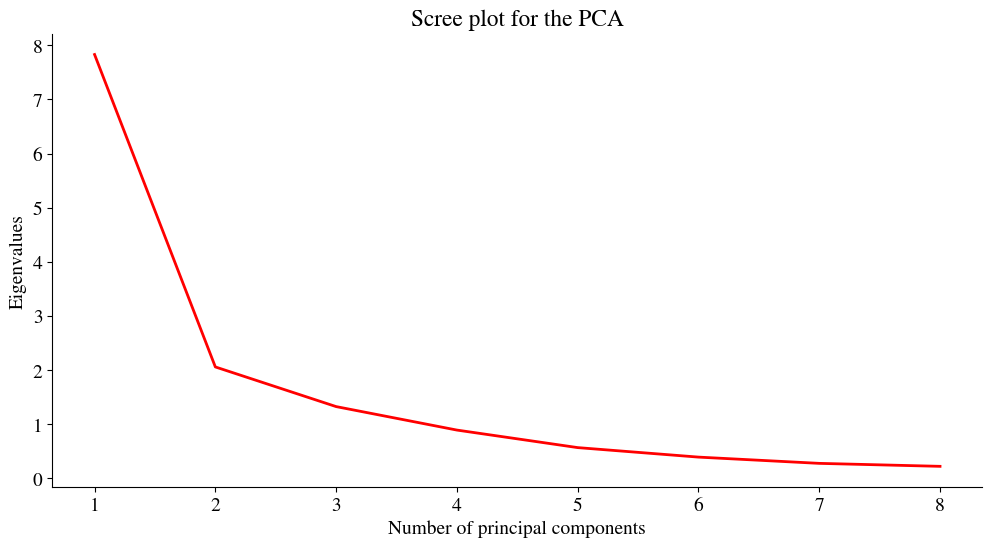

The 1st Principal Component explains 55.6 % of the variance

The 1st and 2nd Principal Components explain 70.2 % of the variance

The 1st, 2nd and 3rd Principal Components explain 79.6 % of the variance

The first four Principal Components explain 85.9 % of the variance



In [11]:
pca = sklearn.decomposition.PCA(n_components=8).fit(auto_scaled)

coef_PCA = pca.transform(auto_scaled)
eig = pca.explained_variance_
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
remove_border()
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))

We do the PC decompostion (again) and then save the vectors of PC coefficients in a data frame. This will be our matrix of regressors 

In [12]:
pca = sklearn.decomposition.PCA(n_components=4)

auto_proj = pca.fit_transform(auto_scaled)
mean_auto = pca.mean_
eigenvectors_auto = pca.components_.T

In [13]:
auto_proj_df = pd.DataFrame(auto_proj, columns = ['dimension1', 'dimension2', 'dimension3', 'dimension4'])

In [14]:
auto_proj_df.head()

dimension1  dimension2  dimension3  dimension4
0    0.413885   -0.433333   -0.403975    1.123929
1    2.034757   -1.448552   -0.529596    0.950987
2    3.577836   -0.313214   -0.247209    1.862011
3    4.621975   -0.857512   -0.423106    1.990977
4    0.638847   -1.285617    1.397892    0.555535

In [15]:
auto_proj_df['loss'] =  loss

In [16]:
auto_proj_df.dtypes

dimension1    float64
dimension2    float64
dimension3    float64
dimension4    float64
loss            int64
dtype: object

Let's plot the 1st Principal Component against the target - the risk score

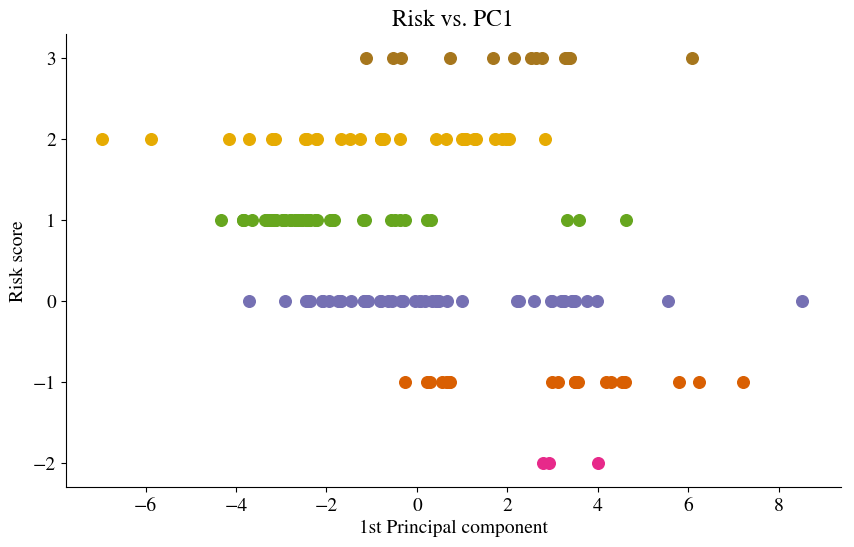

In [17]:
labels = [str(x) for x in list(range(-3,4))]
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], risk[i], s = 70, zorder=0, c=dark2_colors[(risk[i]+3)])
plt.ylabel('Risk score' )
plt.xlabel('1st Principal component' )
plt.title('Risk vs. PC1')
remove_border()
plt.show()

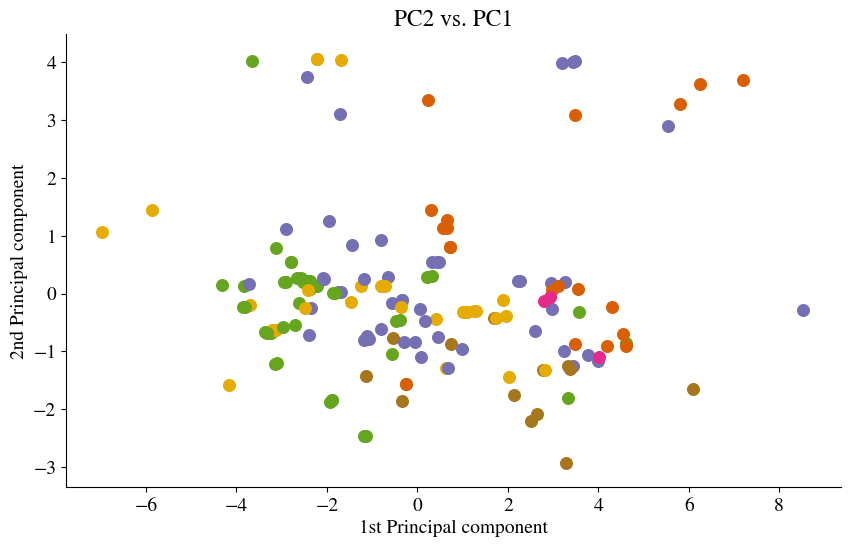

In [18]:
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj[i,1], s = 70, zorder=0, c=dark2_colors[(risk[i]+3)])  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

Ok - we have the principal components, but what we are really interested in is the loss - and how can we tell with a new client (i.e. auto) whether they will have a high loss score?

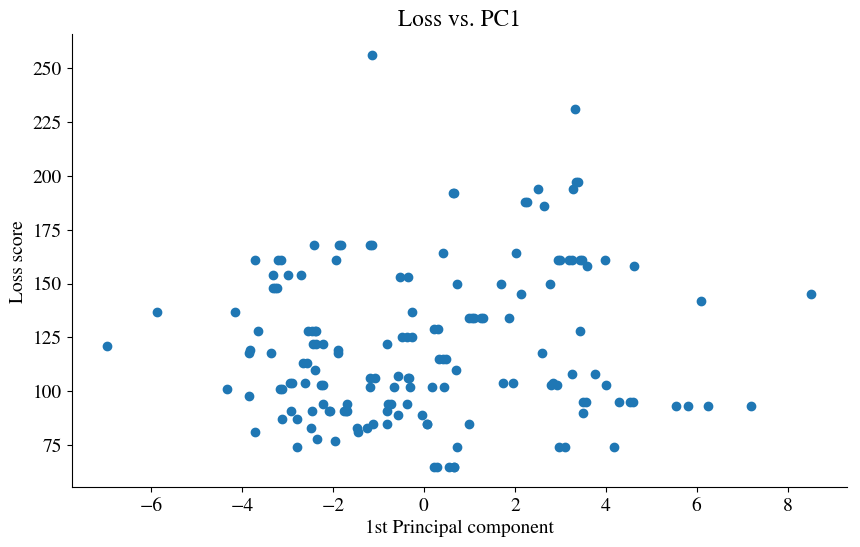

In [19]:
plt.figure(figsize=(10,6))
plt.scatter( auto_proj[:,0],loss)
plt.ylabel('Loss score' )
plt.xlabel('1st Principal component' )
plt.title('Loss vs. PC1')
remove_border()
plt.show()

### Let's be more rigorous about our choice of the number of components. This is also good opportunity to introduce a simple SciKitLearn pipeline for grid search cross validation.

[Pipeline example from SciKit Learn pipeline documentation - with examples](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

[Pipeline example from SciKit Learn examples](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py)

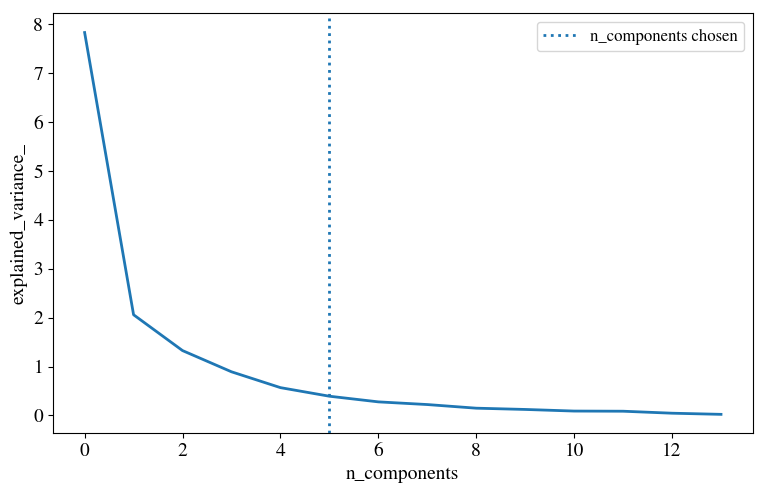

In [18]:
# source
# http://scikit-learn.org/0.18/auto_examples/plot_digits_pipe.html
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = decomposition.PCA()
linear = linear_model.LinearRegression(fit_intercept=True)

pipe = Pipeline(steps=[('pca', pca), ('linear regression', linear)])

# Plot the PCA spectrum
pca.fit(auto_scaled)

plt.figure(1, figsize=(10,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

n_components = [2,3,4,5,6,7,8, 9]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(auto_scaled, loss)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [19]:
pca = sklearn.decomposition.PCA(n_components=5)

auto_proj = pca.fit_transform(auto_scaled)
mean_auto = pca.mean_

linear.fit(auto_proj, loss)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# 1988 Peugeot 405GRDT
fourofive = np.array([105.1, 173.5, 66.6, 55.4, 2535, 116.25, 3.27, 3.46, 21.8, 92, 4150,28,33,17950])
# 1995 BMW 325TD
bmw325 = np.array([106.3, 174.5, 66.9, 54.8, 2943, 152.44, 3.15, 3.27, 22, 113.5, 4800, 26.4, 46.1, 35000])
# 1987 Porsche 928 S4
porsche928 = np.array([98.40,178.0,72.30,50.50,3417,302,3.94,3.11,10.00,316,6000,12,25,46000])
# 2003 Volkswagen Passat Stationwagon TDI
vwpassat = np.array([106.4, 184.3, 68.7, 59.0, 3283, 120.1, 3.19, 3.76, 18.5, 134, 4000, 28, 37.3, 18000])
# 2016 Ford Mustang GT
mustang50 = np.array([107.1, 188.3, 75.4, 54.3, 3716, 302, 3.63, 3.65, 11, 435, 6500, 14.0, 17.0, 38000])

mycars = ['Peugeot', 'BMW', 'Porsche', 'VW', 'Mustang']

In [21]:
auto_test = np.vstack((fourofive,bmw325, porsche928, vwpassat, mustang50))
auto_test.shape

(5, 14)

First scale the new data with the standard scaler from above

In [22]:
# could do this, but in fact I want to use StandardScaler
auto_test_scaled = auto_test - scaler.mean_[np.newaxis, :]

In [23]:
auto_test_scaled = scaler.transform(auto_test)

And then transform into the PCA coordinates

In [24]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-dark-palette')   
set_mpl_params()

In [25]:
test_coords = pca.transform(auto_test_scaled)

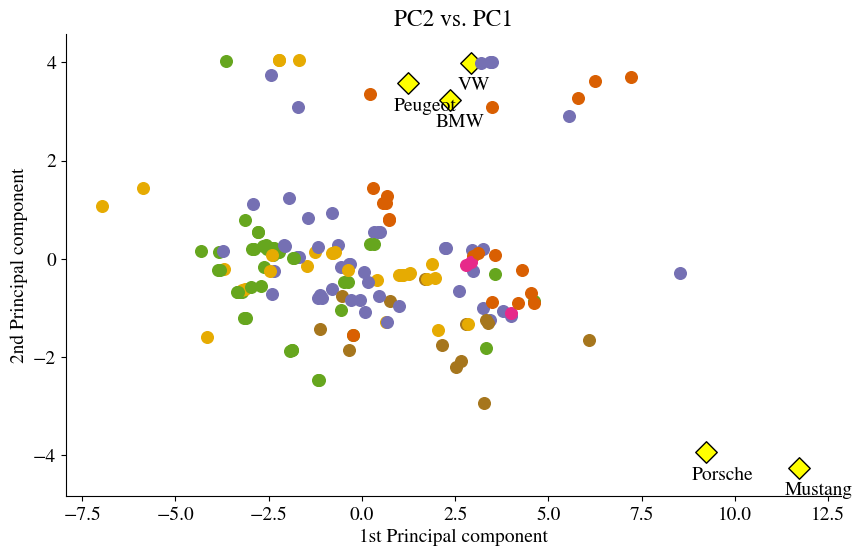

In [26]:
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj[i,1], s = 70, zorder=1, c=dark2_colors[(risk[i]+3)])  
for i in range(test_coords.shape[0]):
    plt.scatter(test_coords[i,0], test_coords[i,1], s = 120, marker="D", \
                zorder=0, c='yellow',edgecolors='black') 
    plt.annotate(mycars[i], (test_coords[i,0],test_coords[i,1]), xytext=(-10, -10), textcoords='offset points', ha='left', va='top') 
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
remove_border()
plt.show()

In [27]:
loss_fit = linear.predict(test_coords)

print (loss_fit)

[104.71396615 141.62579356 251.88723515  88.78273214 250.14256512]


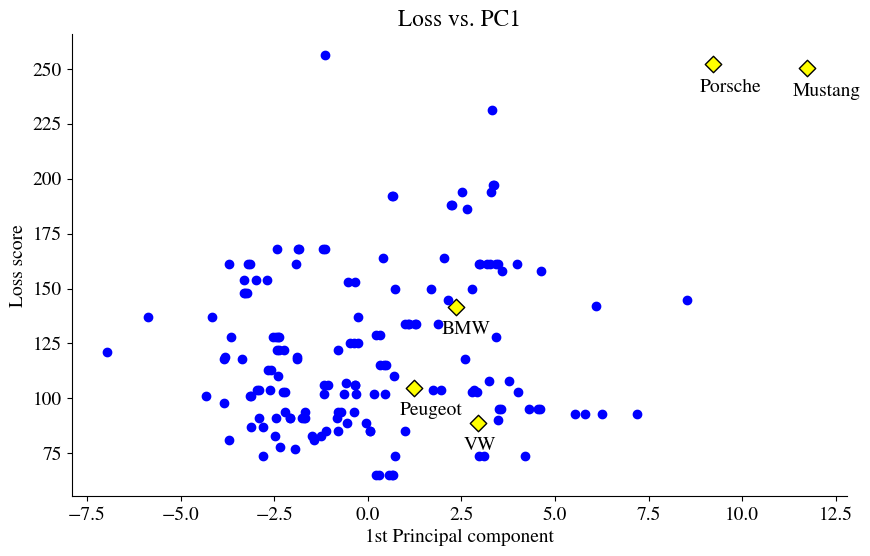

In [28]:
plt.figure(figsize=(10,6))
plt.scatter( auto_proj[:,0],loss, c='blue')
plt.scatter( test_coords[:,0],loss_fit, s = 70, marker="D", zorder=0, c='yellow',edgecolors='black')
for i in range(test_coords.shape[0]):
    plt.annotate(mycars[i], (test_coords[i,0],loss_fit[i]),  xytext=(-10, -10), textcoords='offset points', ha='left', va='top') 
plt.ylabel('Loss score' )
plt.xlabel('1st Principal component' )
plt.title('Loss vs. PC1')
remove_border()
plt.show()

-------

# Other types of regression/curve fitting


![modeling](https://imgs.xkcd.com/comics/curve_fitting.png) 

From the webcomic XKCD: https://xkcd.com/2048/

<a id='logisticregression'></a>
[back to top](#top)


Logistic Regression
----


### Let's back up, and look at the problem in another way.

How do we predict whether a particular vehicle is going to be risky or safe? This becomes a binary classification problem, for which we can use logistic regression.  

We could use all of the original features as regressors (left to you to try) or we could continue to use PC regressors (this example).


[Pipeline PCA/Logistic Regression example from SciKit Learn examples](http://scikit-learn.org/0.18/auto_examples/plot_digits_pipe.html)

In [29]:
auto_proj_df['risk'] = np.where(risk > 0,1,0) 

In [30]:
auto_proj_df.head()

dimension1  dimension2  dimension3  dimension4  loss  risk
0    0.413885   -0.433333   -0.403975    1.123929   164     1
1    2.034757   -1.448552   -0.529596    0.950987   164     1
2    3.577836   -0.313214   -0.247209    1.862011   158     1
3    4.621975   -0.857512   -0.423106    1.990977   158     1
4    0.638847   -1.285617    1.397892    0.555535   192     1

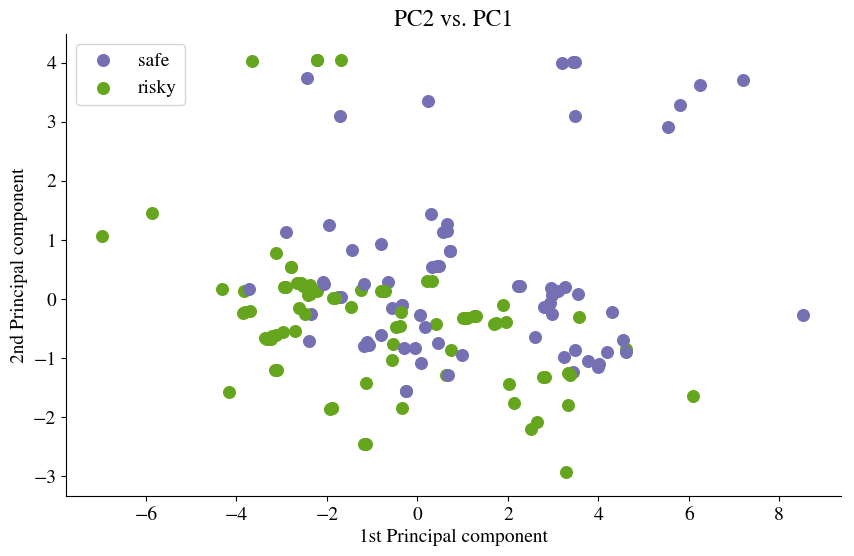

In [31]:
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj[i,1], s = 70, zorder=0, c=dark2_colors[(auto_proj_df['risk'][i]+3)])  
plt.ylabel('2nd Principal component' )
plt.xlabel('1st Principal component' )
plt.title('PC2 vs. PC1')
label=['safe', 'risky', ]
for i in range(len(label)):  ## really hacky way to get legend
    plt.scatter(None, None, s = 70, c = dark2_colors[(i+3)],label=label[i])
plt.legend()
remove_border()
plt.show()

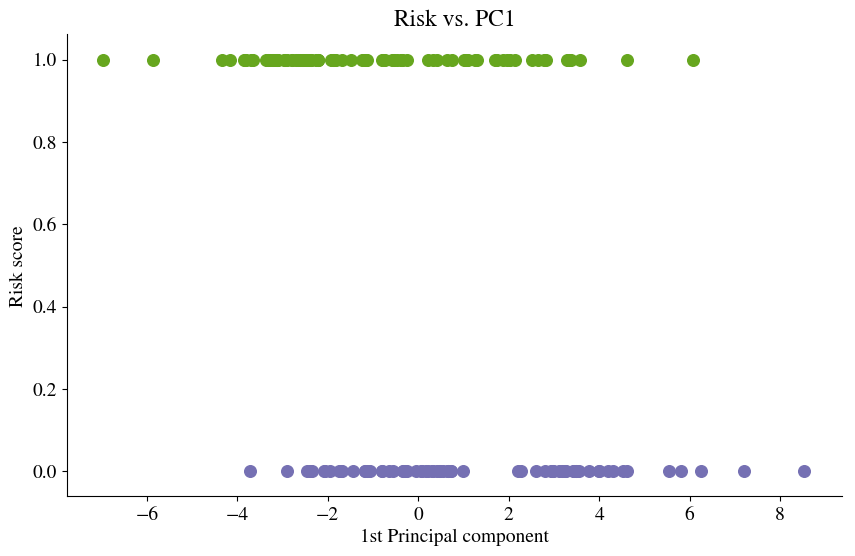

In [32]:
labels = [str(x) for x in list(range(-3,4))]
plt.figure(figsize=(10,6))
for i in range(auto_proj.shape[0]):
    plt.scatter(auto_proj[i,0], auto_proj_df['risk'][i], s = 70, zorder=0, c=dark2_colors[(auto_proj_df['risk'][i]+3)])
plt.ylabel('Risk score' )
plt.xlabel('1st Principal component' )
plt.title('Risk vs. PC1')
remove_border()
plt.show()

In [33]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

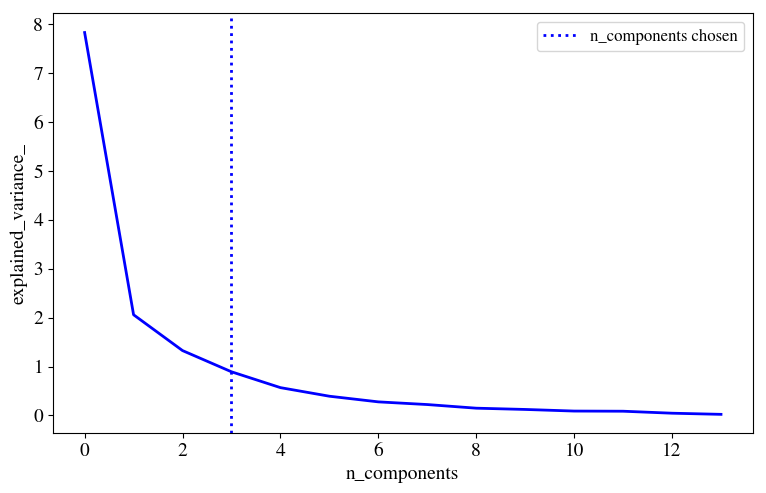

In [34]:

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(auto_scaled)

plt.figure(1, figsize=(10,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2, c='b')
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

n_components = [2,3,4,5,6,7,8, 9]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(auto_scaled, auto_proj_df['risk'])

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen', c='b')
plt.legend(prop=dict(size=12))
plt.show()

In [35]:
pca = sklearn.decomposition.PCA(n_components=3)

auto_proj = pca.fit_transform(auto_scaled)
mean_auto = pca.mean_

logistic.fit(auto_proj, auto_proj_df['risk'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

[0 0 1 0 1]


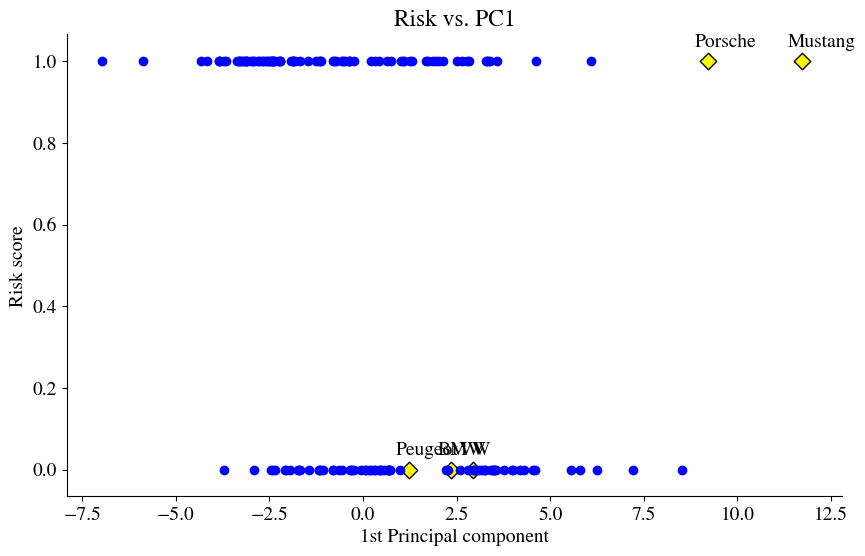

In [36]:
test_coords = pca.transform(auto_test_scaled)
risk_fit = logistic.predict(test_coords)

print (risk_fit)

plt.figure(figsize=(10,6))
plt.scatter( auto_proj[:,0],auto_proj_df['risk'], c='blue')
plt.scatter( test_coords[:,0],risk_fit, s = 70, marker="D", zorder=0, c='yellow',edgecolors='black')
for i in range(test_coords.shape[0]):
    plt.annotate(mycars[i], (test_coords[i,0],risk_fit[i]),  xytext=(-10, 20), textcoords='offset points', ha='left', va='top') 
plt.ylabel('Risk score' )
plt.xlabel('1st Principal component' )
plt.title('Risk vs. PC1')
remove_border()
plt.show()

### Another example with the [spambase dataset](https://archive.ics.uci.edu/ml/datasets/Spambase)  


57 Attributes, 1 Target Variable - Spam Y or N 
4601 samples



### Dataset: Spambase

SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)  


48 continuous real [0,100] attributes of type word_freq_WORD      
 = percentage of words in the e-mail that match WORD,     
 i.e. 100 * (number of times the WORD appears in the e-mail) /     
 total number of words in e-mail.  A "word" in this case is any       
 string of alphanumeric characters bounded by non-alphanumeric      
 characters or end-of-string.       


 6 continuous real [0,100] attributes of type char_freq_CHAR     
 = percentage of characters in the e-mail that match CHAR,     
 i.e. 100 * (number of CHAR occurences) / total characters in e-mail     
   
   
 1 continuous real [1,...] attribute of type capital_run_length_average       
 = average length of uninterrupted sequences of capital letters     
      
  
 1 continuous integer [1,...] attribute of type capital_run_length_longest    
 = length of longest uninterrupted sequence of capital letters      
    
 
 1 continuous integer [1,...] attribute of type capital_run_length_total    
 = sum of length of uninterrupted sequences of capital letters    
 = total number of capital letters in the e-mail   
   
    
 1 nominal {0,1} class attribute of type spam    
 = denotes whether the e-mail was considered spam (1) or not (0),     
 i.e. unsolicited commercial e-mail.     
   
   
 For more information, see file 'spambase.DOCUMENTATION' at the    
 UCI Machine Learning Repository: http://www.ics.uci.edu/~mlearn/MLRepository.html     



1, 0.    | spam, non-spam classes



(4601, 58)
(4601, 57) (2990, 57) (1611, 57)


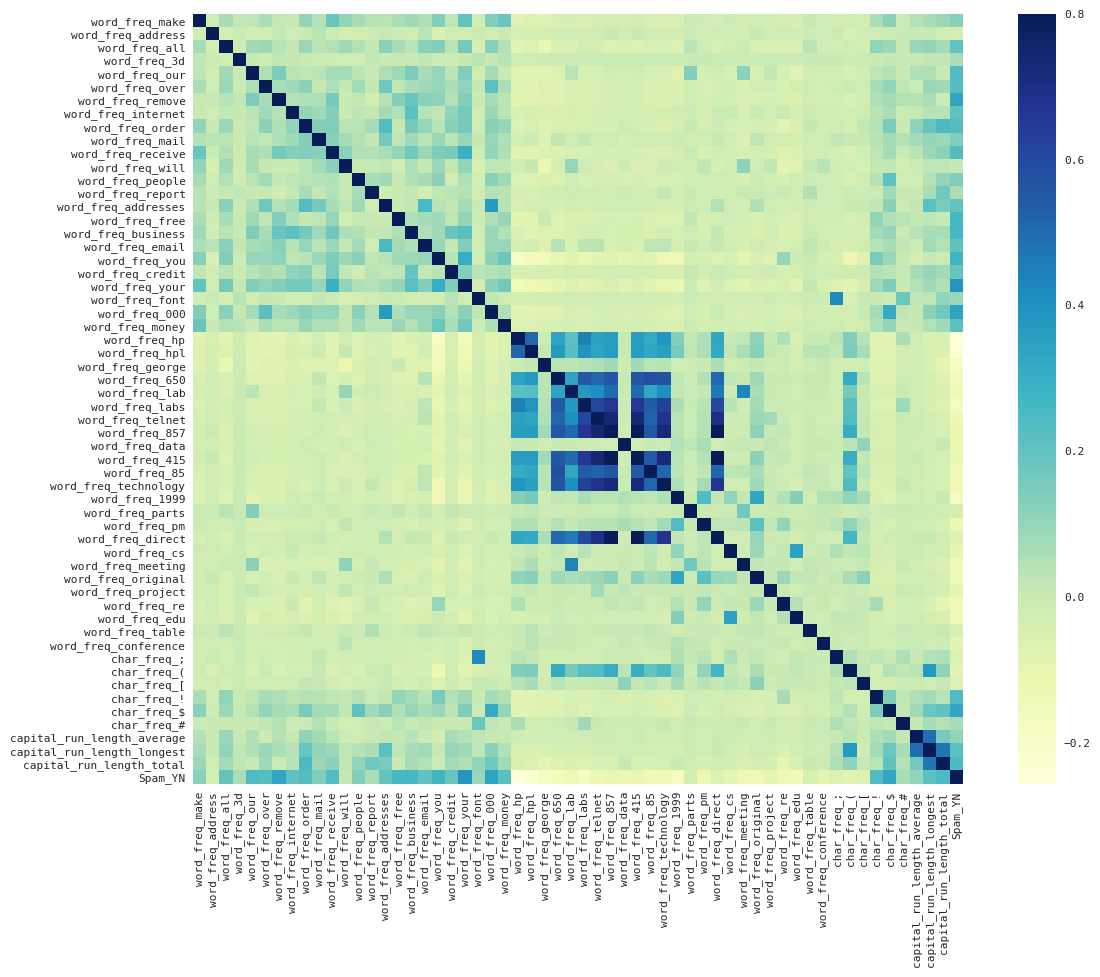

In [37]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
df = pd.read_csv(url,header=None)
df.columns = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d',
'word_freq_our','word_freq_over','word_freq_remove','word_freq_internet',     
'word_freq_order', 'word_freq_mail', 'word_freq_receive','word_freq_will',         
'word_freq_people', 'word_freq_report','word_freq_addresses','word_freq_free',         
'word_freq_business', 'word_freq_email','word_freq_you','word_freq_credit',      
'word_freq_your','word_freq_font',  'word_freq_000', 'word_freq_money',        
'word_freq_hp',  'word_freq_hpl',  'word_freq_george','word_freq_650',          
'word_freq_lab',   'word_freq_labs','word_freq_telnet','word_freq_857',          
'word_freq_data',  'word_freq_415', 'word_freq_85',    'word_freq_technology',
'word_freq_1999','word_freq_parts', 'word_freq_pm',  'word_freq_direct',     
'word_freq_cs',  'word_freq_meeting','word_freq_original','word_freq_project',      
'word_freq_re', 'word_freq_edu',     'word_freq_table',  'word_freq_conference', 
'char_freq_;', 'char_freq_(', 'char_freq_[',  'char_freq_!',            
'char_freq_$',  'char_freq_#','capital_run_length_average','capital_run_length_longest', 
'capital_run_length_total', 'Spam_YN']

print(df.shape)
df.head()

df.Spam_YN.value_counts()/df.shape[0]

##**Correlation Plot**

import seaborn as sns
sns.set(context="paper", font="monospace")

corrmat = df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

# Draw the heatmap using seaborn
_ = sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")

x = df.iloc[:,0:57]
y = df.Spam_YN

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=10) 
print (x.shape, x_train.shape, x_test.shape)

In [38]:
target_names = ['ham', 'spam']

def show_confusion_matrix(cm):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

accuracy: 0.92675
Accuracy score: 0.92675" 
 

Confusion_matrix: 
 [[914  48]
 [ 70 579]]


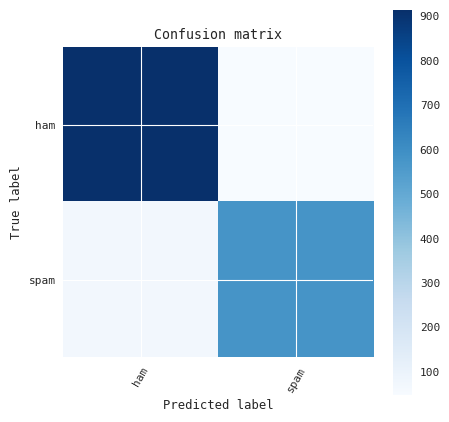

In [39]:
# alpha is additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
logistic = linear_model.LogisticRegression()

# Training the classifier
logistic.fit(x_train, y_train)

# Predicting results
y_predicted_logistic = logistic.predict(x_test)

score = metrics.accuracy_score(y_test, y_predicted_logistic)
print("accuracy: %0.5f" % score)

#SVM_predprobability = clf.predict_proba(X_test)
print ('Accuracy score: %0.5f" \n' % score, '\n')

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted_logistic)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix)

<a id='Time-Series-Seasonality'></a>


Seasonality in time series
=====

[Back to top](#top)


In [40]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()
mpl.style.use('ggplot')
#mpl.style.use('seaborn-dark-palette')   

------



## A first simple example - quarterly US Wholesale Production Index

In [41]:
prod = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
prod = pd.read_stata(BytesIO(prod))
prod.index = prod.t

prod['ln_wpi_diff'] = prod['ln_wpi'].diff()
prod.dropna(inplace=True)

prod.head()

wpi          t    ln_wpi  ln_wpi_diff
t                                                      
1960-04-01  30.799999 1960-04-01  3.427515     0.003252
1960-07-01  30.700001 1960-07-01  3.424263    -0.003252
1960-10-01  30.700001 1960-10-01  3.424263     0.000000
1961-01-01  30.799999 1961-01-01  3.427515     0.003252
1961-04-01  30.500000 1961-04-01  3.417727    -0.009788

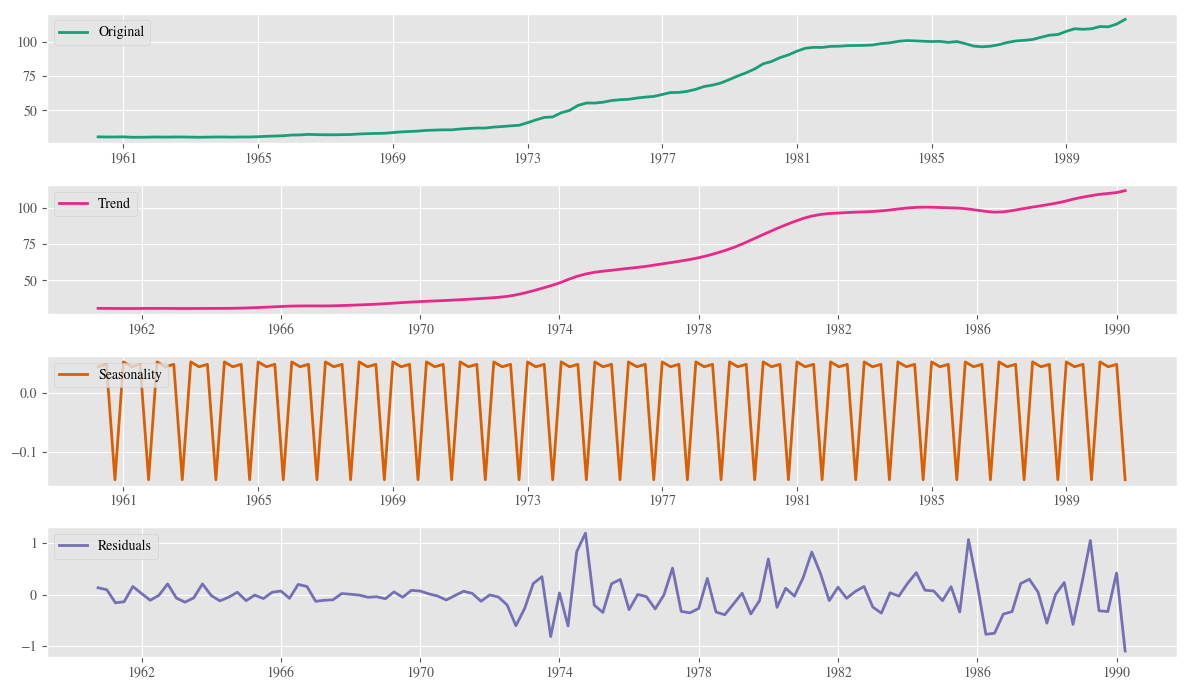

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series) 

    f, ax = plt.subplots(1,4,figsize=(12, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return decomposition

decomposition = breakout_plots(prod['wpi'])

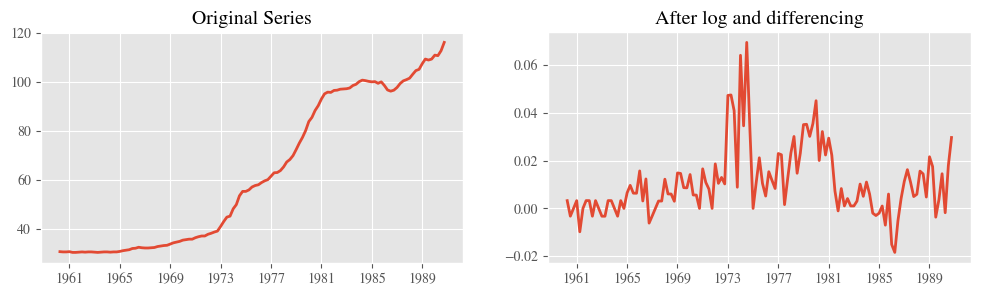

In [43]:
#Plot the data
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(prod['wpi']);
ax[0].set_title('Original Series')
ax[1].plot(prod['ln_wpi_diff']);
ax[1].set_title('After log and differencing');

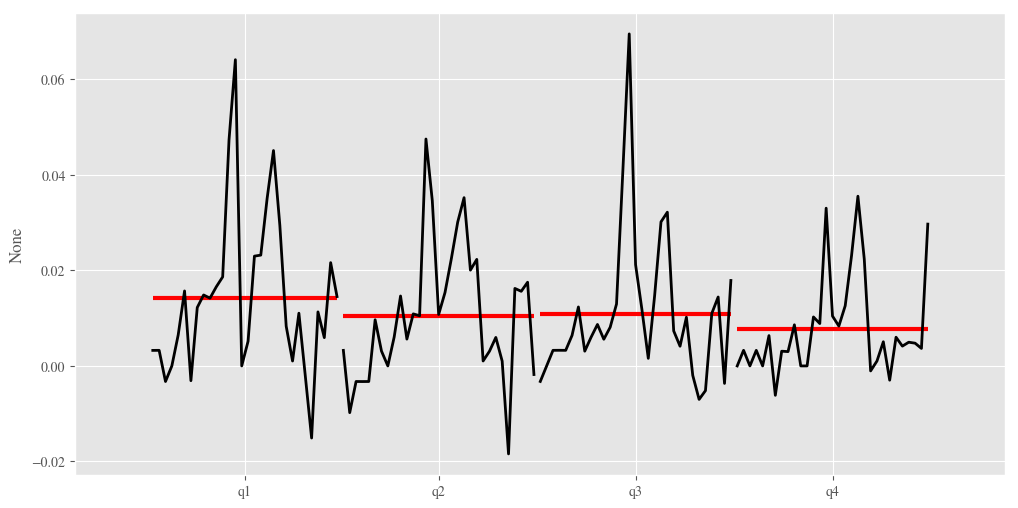

In [44]:
## Very nice plot to break up time series into seasonal components 
## - works OK for quarterly seasonality

_ = smg.tsa.quarter_plot(prod['ln_wpi_diff'])

## Seasonal Decomposition

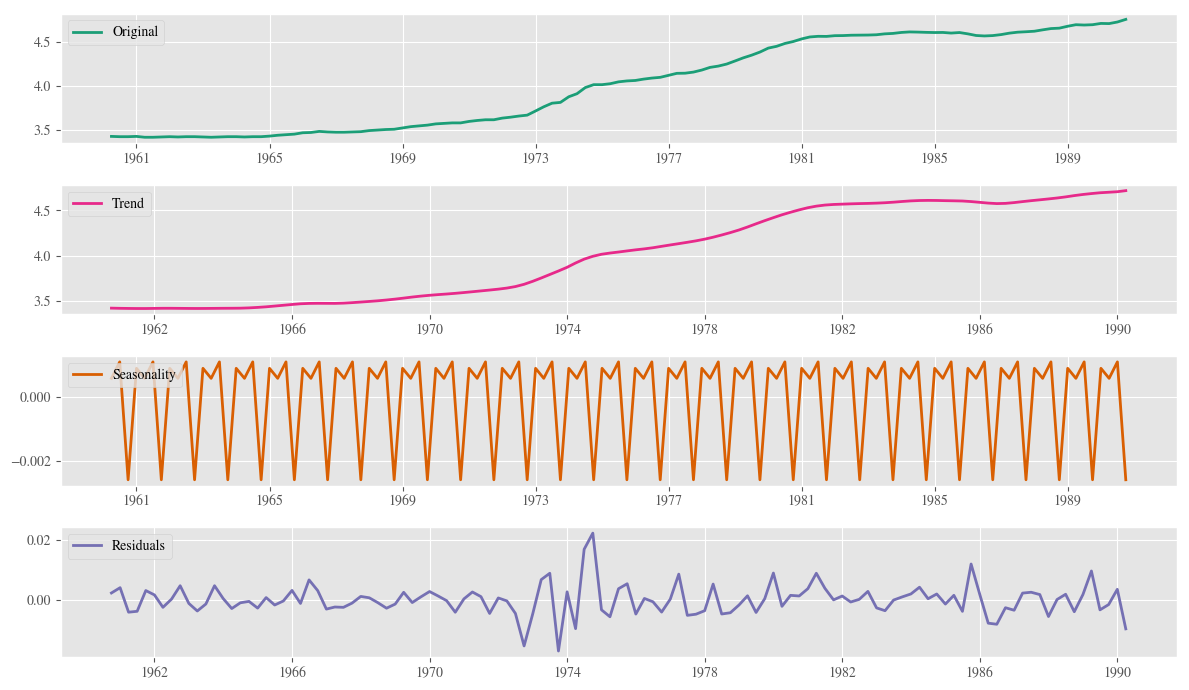

In [45]:
## plot out the components of the time series
decomposition = breakout_plots(prod['ln_wpi']) # try both prod['ln_wpi'] and  prod['ln_wpi_diff']

### ACF and PACF plots

We look at the ACF and PACF plots for the log first-differenced series - what should we expect in the PACF?

In [46]:
#seaborn.set(style='ticks', context='talk')

def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    seaborn.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax, lbox_ax

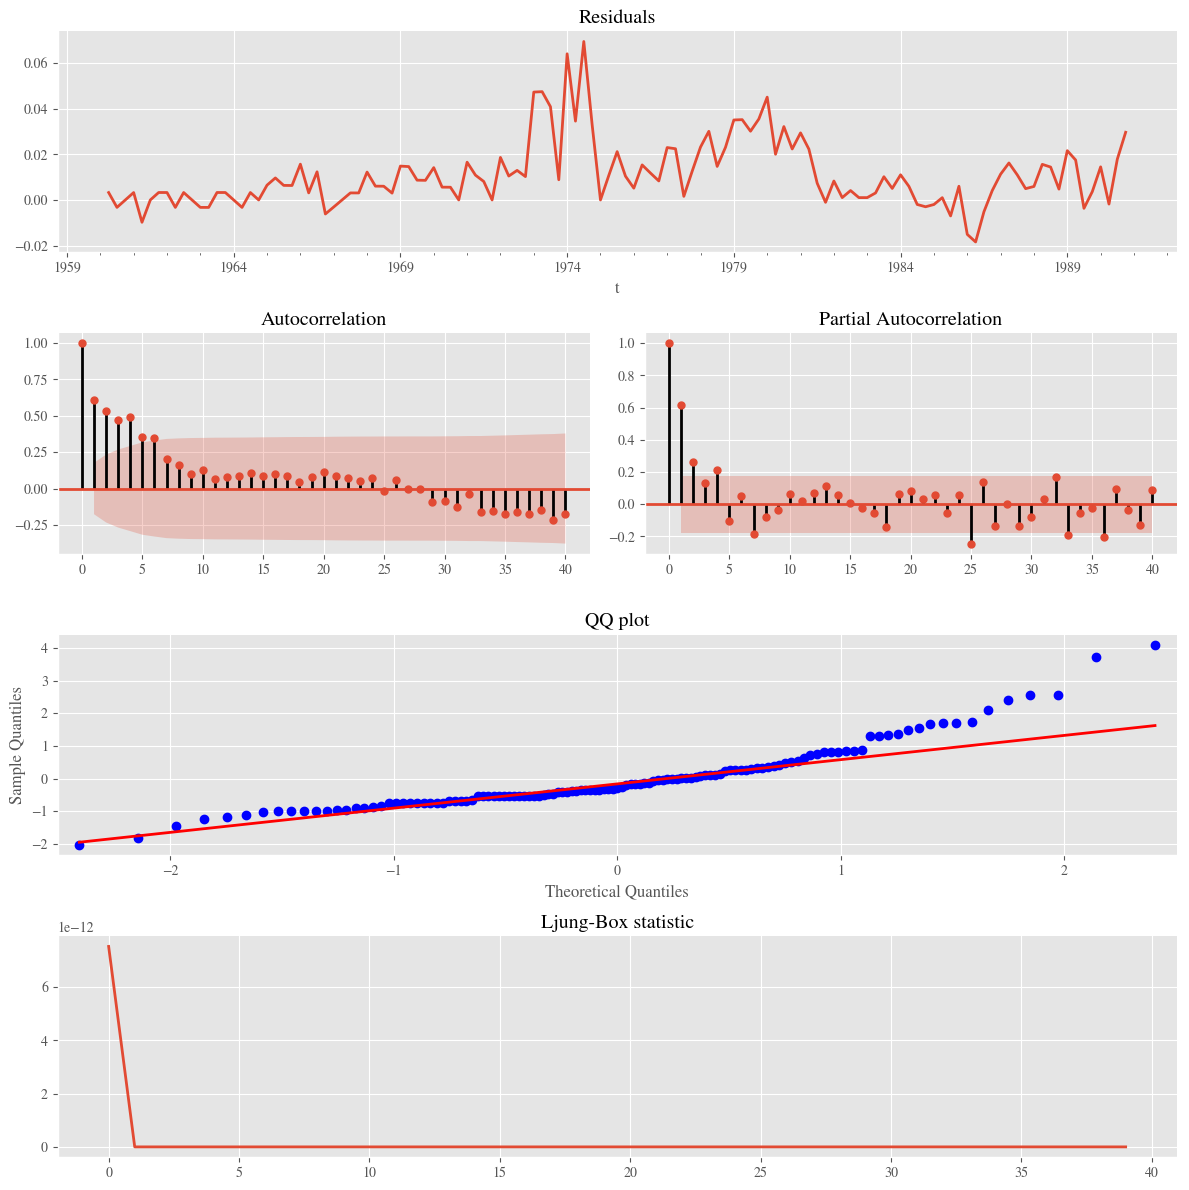

In [47]:
_ = tsplot(prod['ln_wpi_diff'] , 40)

### Plot the residuals

We can also make the same plots for the residuals - note that the decomposition routine is extracting the trend and the seasonal pattern - i.e. it is performing the time series modeling.

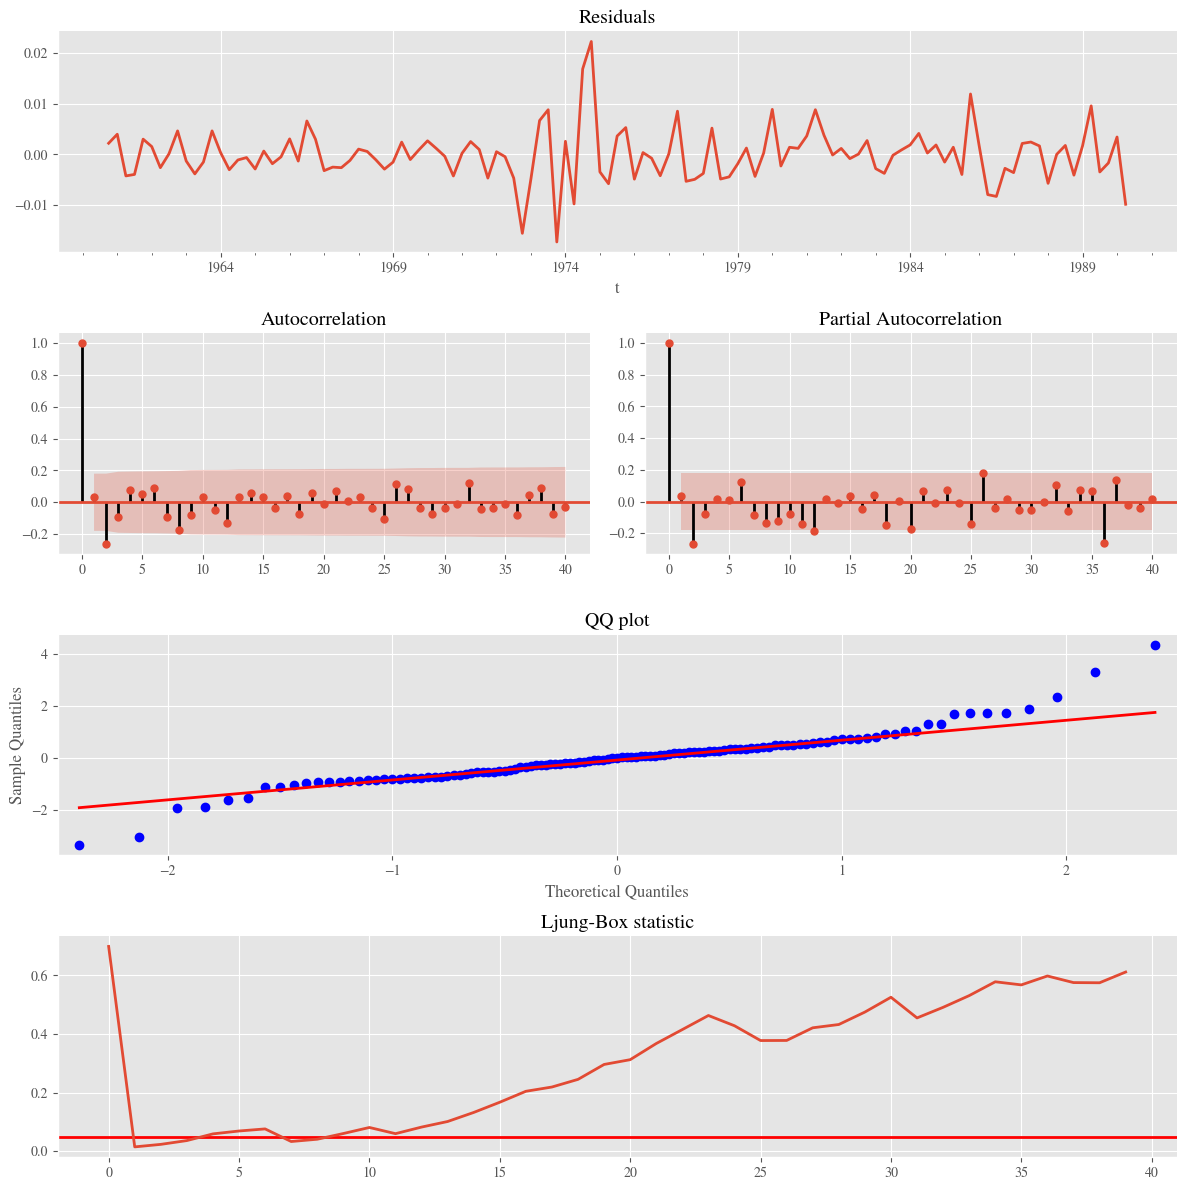

In [48]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

### 1. ARIMA (1,1,1) Model 


The wholesale production index is clearly growing over time - and doesn't satisfy even weak stationarity. We thus cannot use an ARMA model, but rather we need to at least first difference the series. 

The first model choice is one of the simplest: one autoregressive lag and one moving average lag, as well as an intercept term.

The postulated data process is then:

$$
\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_{t}
$$

where $c$ is the intercept of the ARMA model, $\Delta$ is the first-difference operator, and we assume $\epsilon_{t} \sim N(0, \sigma^2)$. This can be rewritten to emphasize lag polynomials as (this will be useful in example 2, below):

$$
(1 - \phi_1 L ) \Delta y_t = c + (1 + \theta_1 L) \epsilon_{t}
$$

where $L$ is the lag operator.

                           Statespace Model Results                           
Dep. Variable:               D.ln_wpi   No. Observations:                  122
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 378.839
Date:                Sat, 06 Oct 2018   AIC                           -749.678
Time:                        19:29:55   BIC                           -738.462
Sample:                    07-01-1960   HQIC                          -745.122
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.335      0.182      -0.001       0.003
ar.L1          0.8846      0.043     20.802      0.000       0.801       0.968
ma.L1         -0.4781      0.092     -5.170      0.0

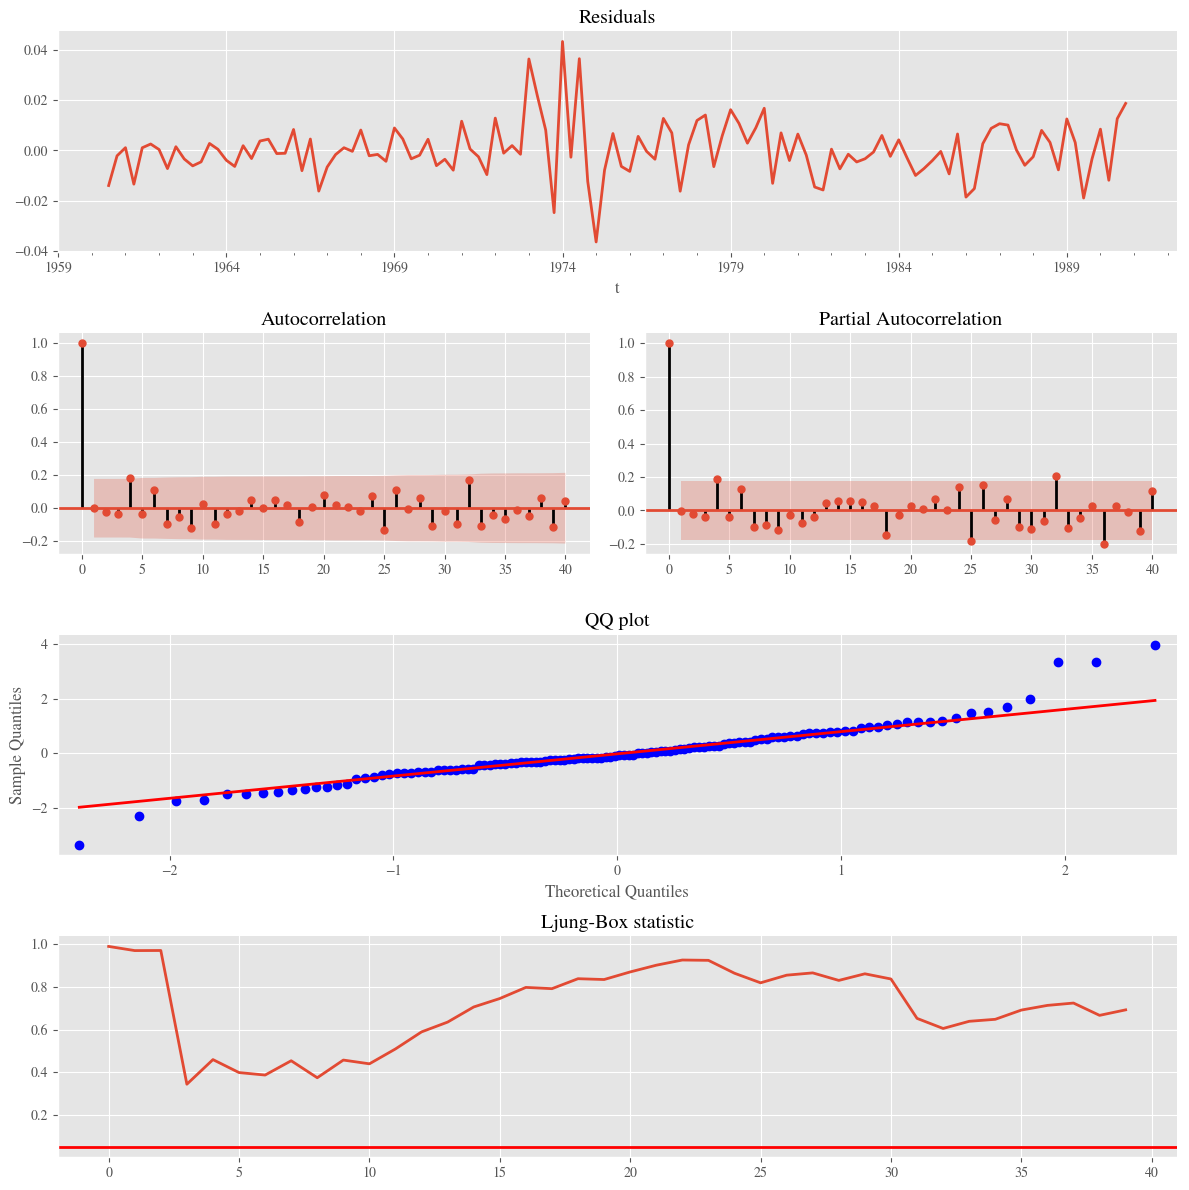

In [49]:
# Fit an ARIMA (1,1,1) model to the log WPI, including an intercept

mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(1,1,1), simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

### 2. ARIMA (1,1,4) Model 

The corresponding data process would be:

$$
y_t = c + \phi_1 y_{t-1} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \theta_3 \epsilon_{t-3} + \theta_4 \epsilon_{t-4} + \epsilon_{t}
$$

or

$$
(1 - \phi_1 L)\Delta y_t = c + (1 + \theta_1 L + \theta_2 L^2 + \theta_3 L^3 + \theta_4 L^4) \epsilon_{t}
$$

When the specification parameter is given as a maximum degree of the lag polynomial, it implies that all polynomial terms up to that degree are included. Notice that this is *not* the model we want to use to capture seasonality because it would include terms for $\epsilon_{t-2}$ and $\epsilon_{t-3}$, which we don't want.

/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:               D.ln_wpi   No. Observations:                  122
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 382.631
Date:                Sat, 06 Oct 2018   AIC                           -751.262
Time:                        19:29:56   BIC                           -731.633
Sample:                    07-01-1960   HQIC                          -743.289
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.002      1.576      0.115      -0.001       0.006
ar.L1          0.7463      0.112      6.675      0.000       0.527       0.965
ma.L1         -0.3867      0.133     -2.910      0.0

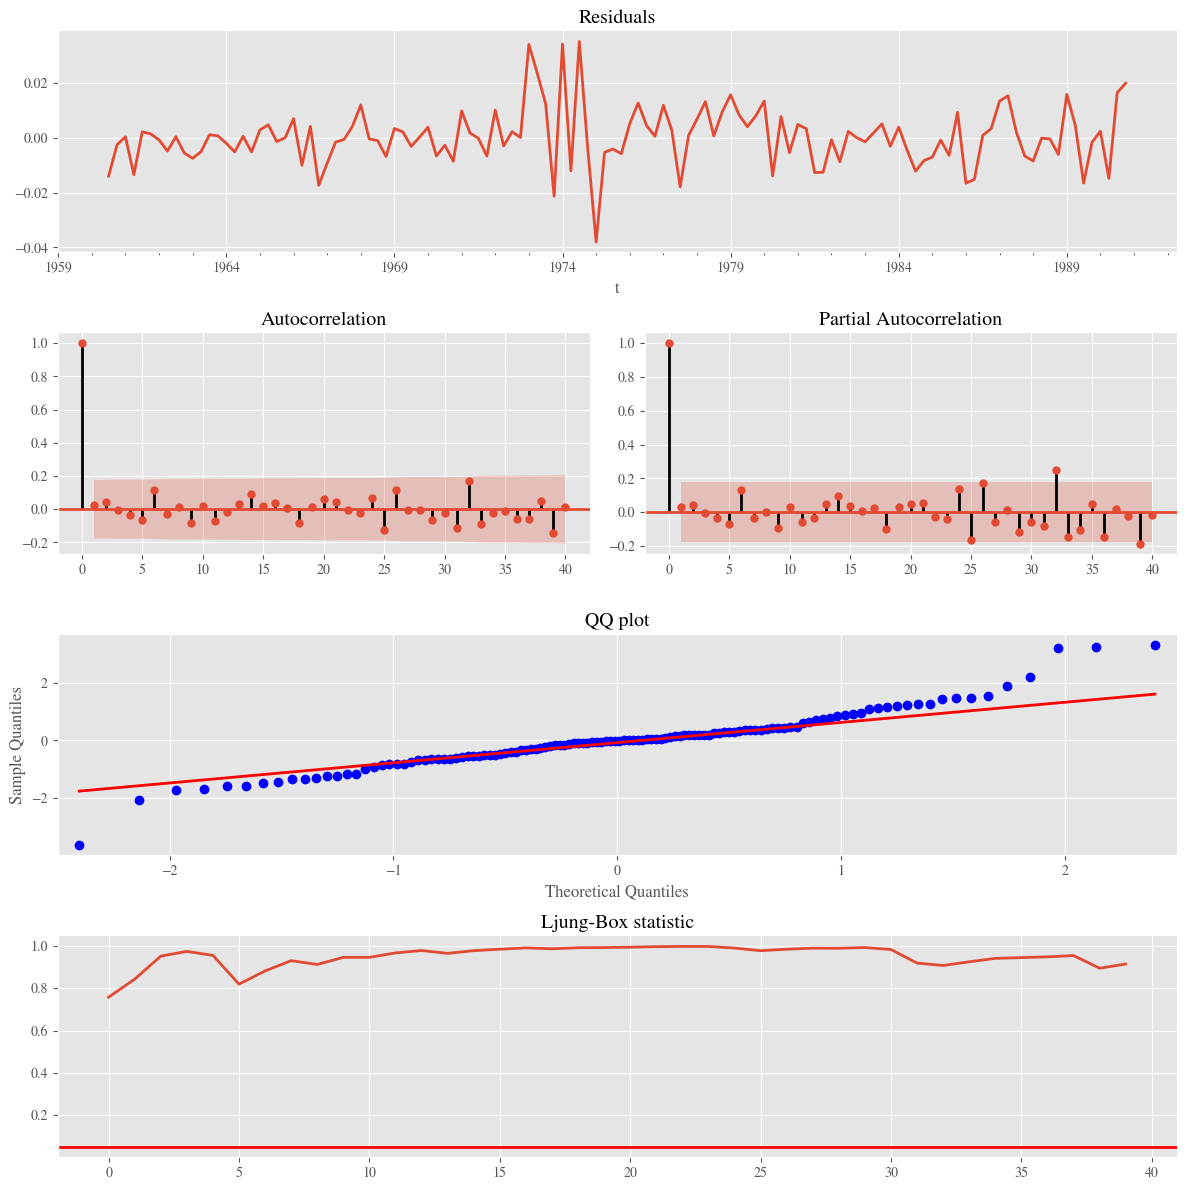

In [50]:
# Fit an ARIMA (1,1,4)  - additional lags to capture the quartlerly error effects
mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(1,1,4), simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())


_ = tsplot(results_ARIMA.resid, 40)

### 3. Seasonal ARIMA model (1,1,1) with seasonal pattern with "additive" MA term


What we want is a polynomial that has terms for the 1st and 4th degrees, but leaves out the 2nd and 3rd terms. To do that, we need to provide a tuple for the specifiation parameter, where the tuple describes **the lag polynomial itself**. In particular, here we would want to use:

$$
\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_1 \epsilon_{t-1} + \theta_4 \epsilon_{t-4} + \epsilon_{t} \\
(1 - \phi_1 L)\Delta y_t = c + (1 + \theta_1 L + \theta_4 L^4) \epsilon_{t}
$$



                             Statespace Model Results                            
Dep. Variable:                  D.ln_wpi   No. Observations:                  122
Model:             SARIMAX(1, 0, (1, 4))   Log Likelihood                 382.262
Date:                   Sat, 06 Oct 2018   AIC                           -754.524
Time:                           19:29:56   BIC                           -740.504
Sample:                       07-01-1960   HQIC                          -748.830
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.002      1.728      0.084      -0.000       0.006
ar.L1          0.7241      0.100      7.214      0.000       0.527       0.921
ma.L1         -0.3427      0

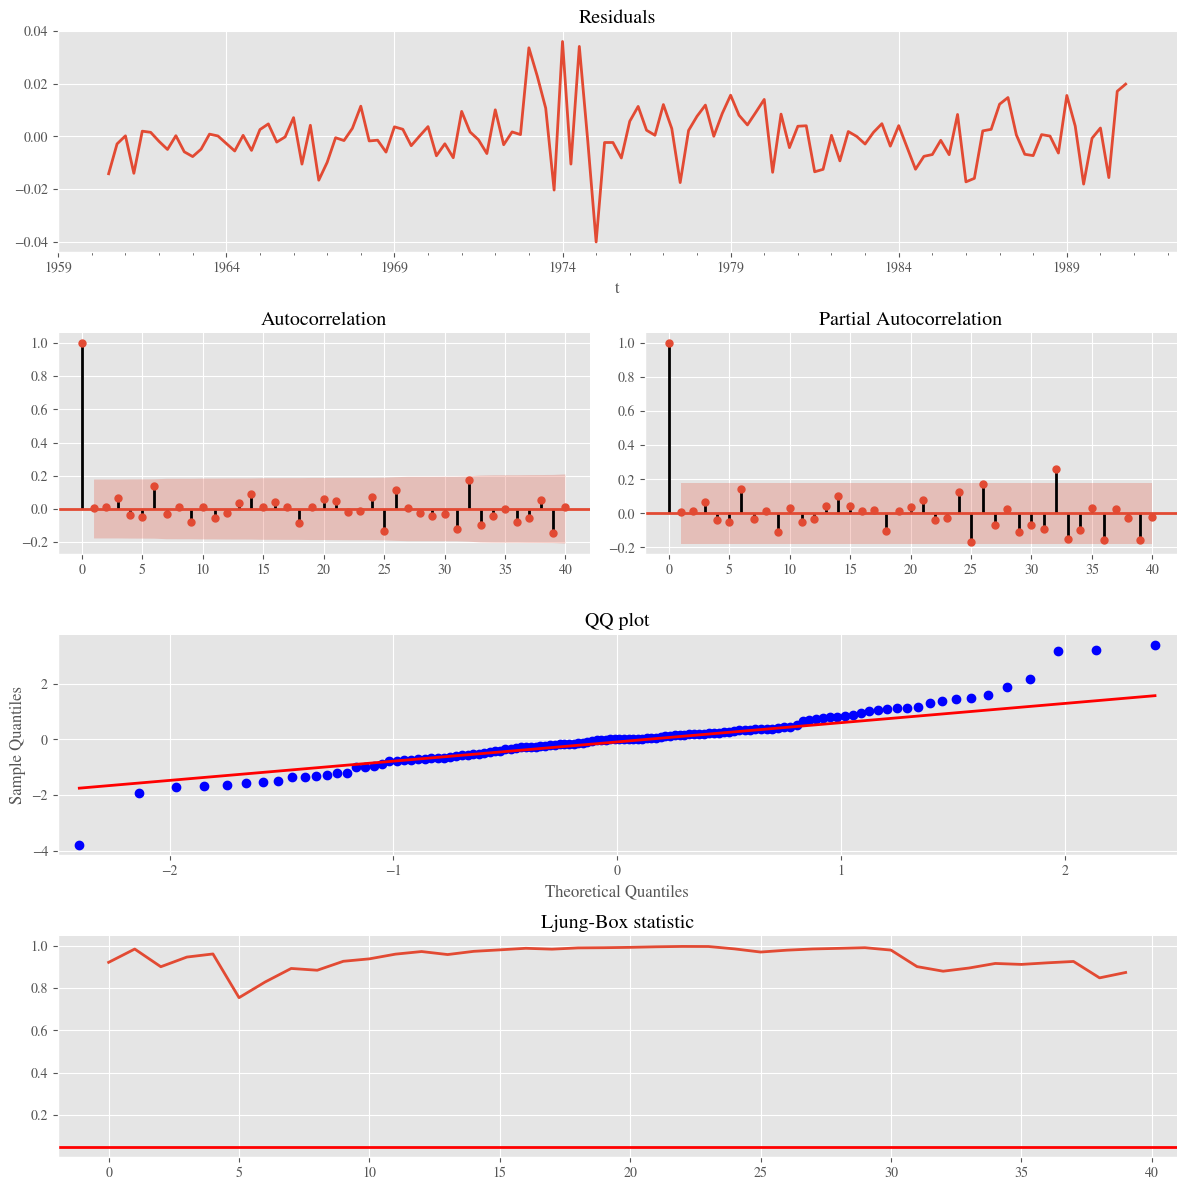

In [51]:
# Fit an ARIMA model with a specified MA structure

ar = 1 
ma = (1,0,0,1)
mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(ar,1,ma), simple_differencing=True)

## ARIMA (1,1,1) x (0,1,4)12 - seasonal ARIMA to capture the quartlerly effects
#mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(1,1,1), seasonal_order=(0,1,1,4), simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

Let's fit a seasonal ARIMA model to the WPI data - ARIMA $(p,d,q) \times (P,D,Q)_s$, where the lowercast letters indicate the specification for the non-seasonal component, and the uppercase letters indicate the specification for the seasonal component

From the [documentation examples on the Statsmodels package](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb), we have the following explanation:

Specifying the model in Statsmodels is done simply by adding the `seasonal_order` argument, which accepts a tuple of the form `(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)`. The seasonal AR and MA specifications, as before, can be expressed as a maximum polynomial degree or as the lag polynomial itself. Seasonal periodicity is an integer.

Note: The explanations of each simple ARIMA model are also taken from the above examples documentation.

                                 Statespace Model Results                                
Dep. Variable:                          D.ln_wpi   No. Observations:                  122
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 4)   Log Likelihood                 381.678
Date:                           Sat, 06 Oct 2018   AIC                           -753.356
Time:                                   19:29:57   BIC                           -739.336
Sample:                               07-01-1960   HQIC                          -747.661
                                    - 10-01-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.001      1.431      0.152      -0.001       0.005
ar.L1          0.8060      0.096      8.425

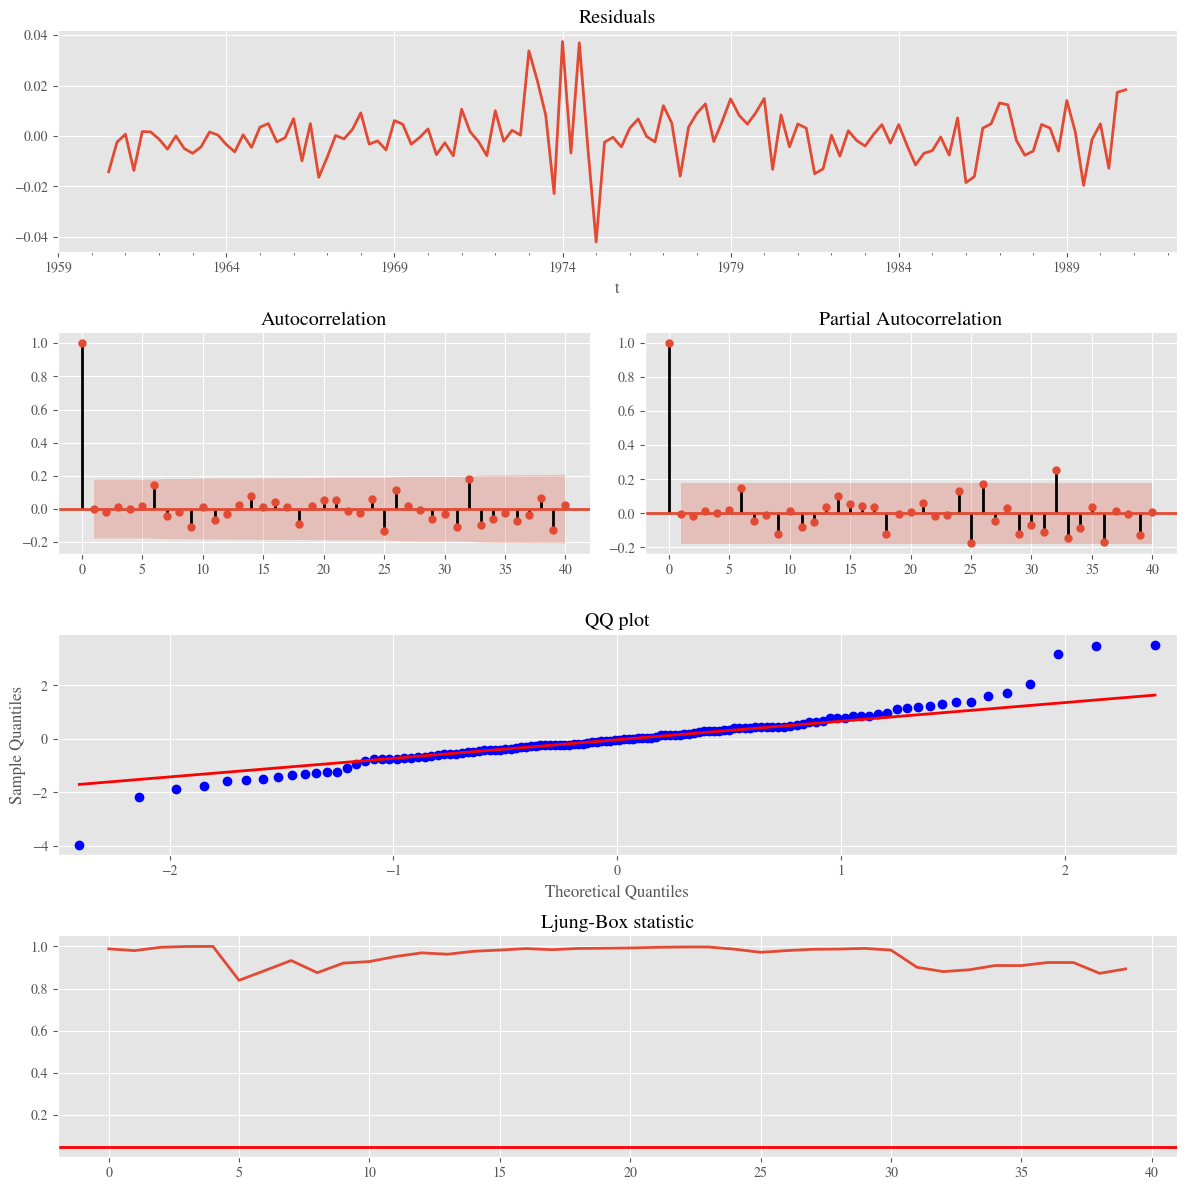

In [52]:
# Fit an ARIMA model with a specified MA structure

#ar = 1 
#ma = (1,0,0,1)
#mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(ar,1,ma), simple_differencing=True)

## ARIMA (1,1,1) x (0,1,4)12 - seasonal ARIMA to capture the quartlerly effects
mod = sm.tsa.statespace.SARIMAX(prod['ln_wpi'], trend='c', freq='QS', order=(1,1,1), seasonal_order=(0,0,1,4), simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

#### Some notes on the practical aspects of seasonal ARIMA models are  [here](http://people.duke.edu/~rnau/411sdif.htm_)

--------


[Back to top](#top)



## Milk production dataset example

This was the example shown in Lecture. 

What is it about milk production that gives rise to seaonality?   
Why would we want to model that? 

In [53]:
url = "https://s3.amazonaws.com/csci-e82-section-data/monthly-milk-production-pounds.csv"
milk = pd.read_csv(url, parse_dates=['Month'],  index_col="Month")
milk.index = pd.to_datetime(milk.index)
milk.head()
#milk.index = pd.date_range(start=datetime(milk.time[0], 1, 1), periods=len(milk), freq='MS')

Production
Month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

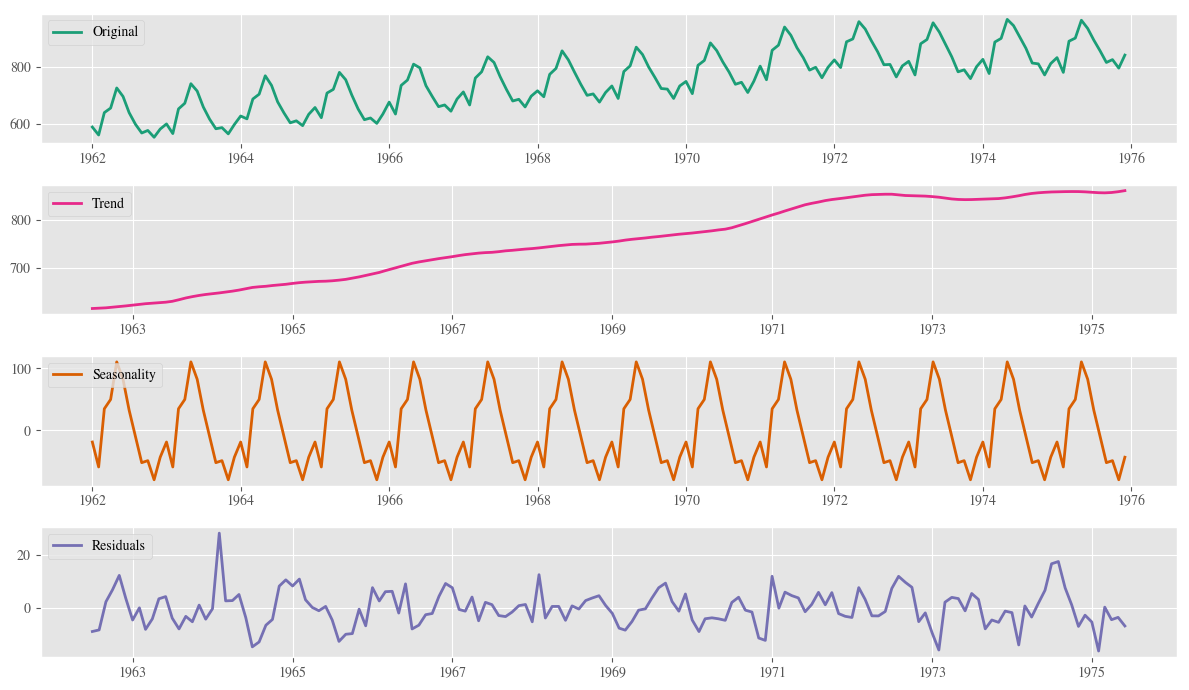

In [54]:
breakout_plots(milk['Production'])

- Increasing trend: take logs, non-seasonal difference
- Strong and consistent seasonal pattern: take seasonal difference
- Additionally - there is a pattern within the seasonal component: ARIMA modelling of seasonal part

In [55]:
milk['log_production'] = np.log(milk['Production'])
milk['log_production_diff']= milk['log_production'].diff()
milk.dropna(inplace=True)   # We drop NAs resulting from the differencing
milk.head()

Production  log_production  log_production_diff
Month                                                      
1962-02-01         561        6.329721            -0.048705
1962-03-01         640        6.461468             0.131747
1962-04-01         656        6.486161             0.024693
1962-05-01         727        6.588926             0.102766
1962-06-01         697        6.546785            -0.042141

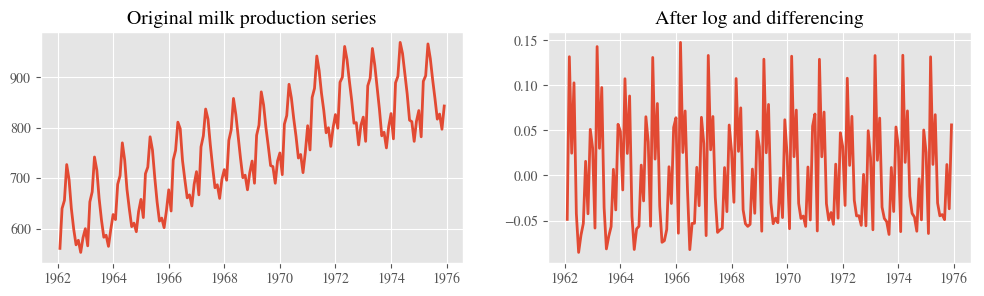

In [56]:
#Plot the data
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(milk['Production']);
ax[0].set_title('Original milk production series')
ax[1].plot(milk['log_production_diff']);
#ax[1].plot(milk['log_production']);
ax[1].set_title('After log and differencing');

- Trend seems to be gone
- Still does not look like white noise

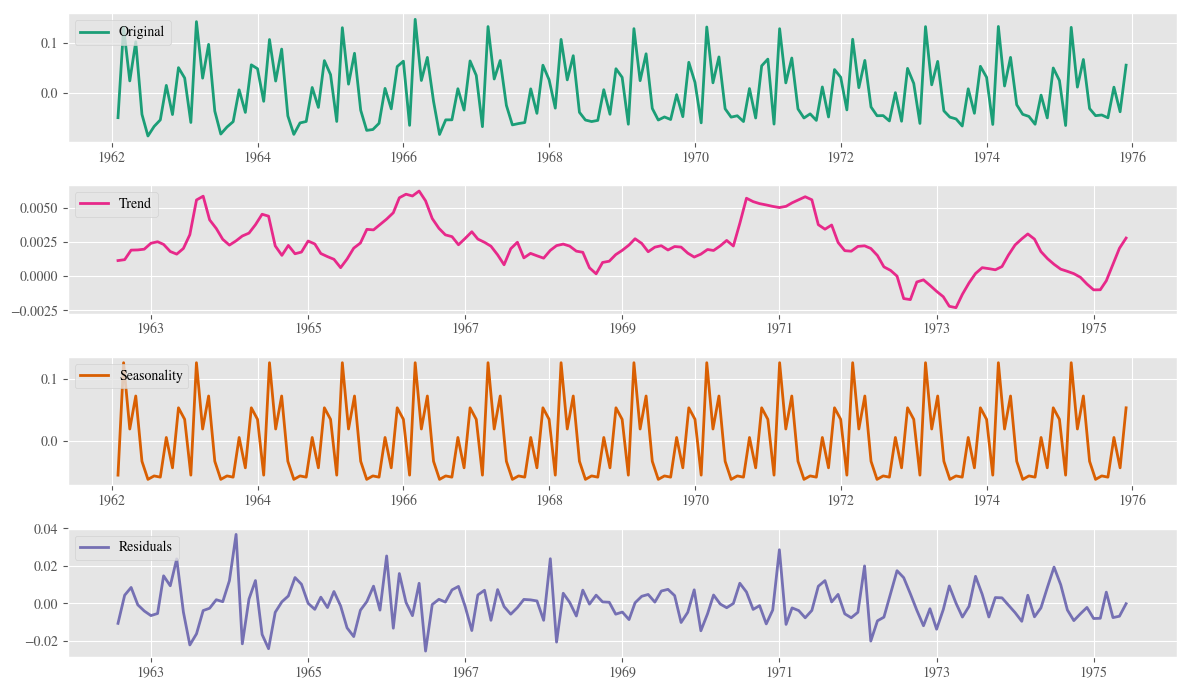

In [57]:
decomposition = breakout_plots(milk['log_production_diff'])

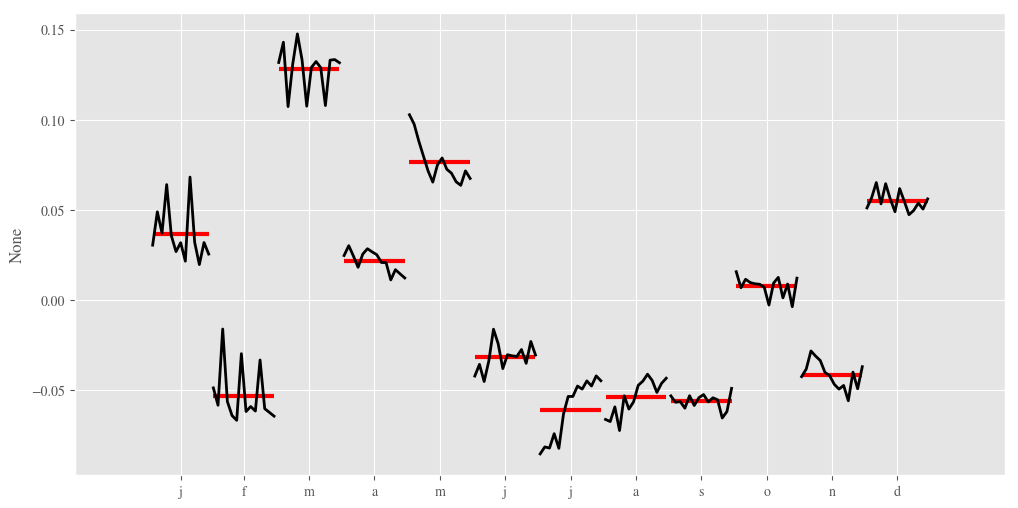

In [58]:
## Very nice plot to break up time series into seasonal components 
## - works even better for monthly seasonality - I think

_ = smg.tsa.month_plot(milk['log_production_diff'])

### ACF and PACF plots

Let's plot the first-differenced series again and look at the ACF and PACF plots

/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


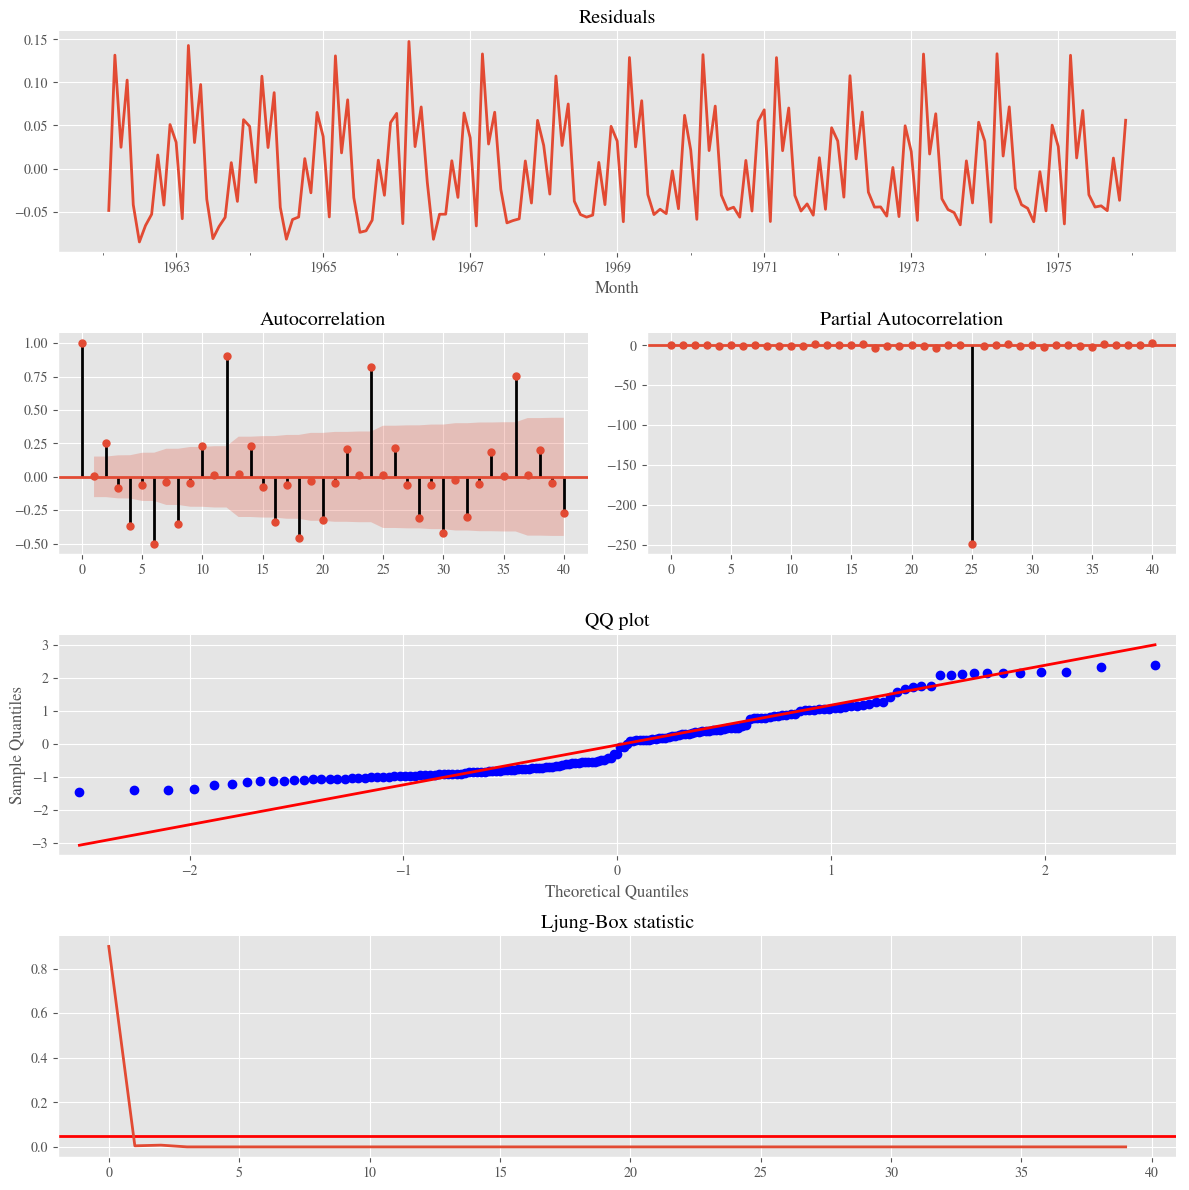

In [59]:
_ = tsplot(milk['log_production_diff'] , 40)

### Plot the residuals

We again make the same plots for the residuals - this should remove the major part of the seasonality

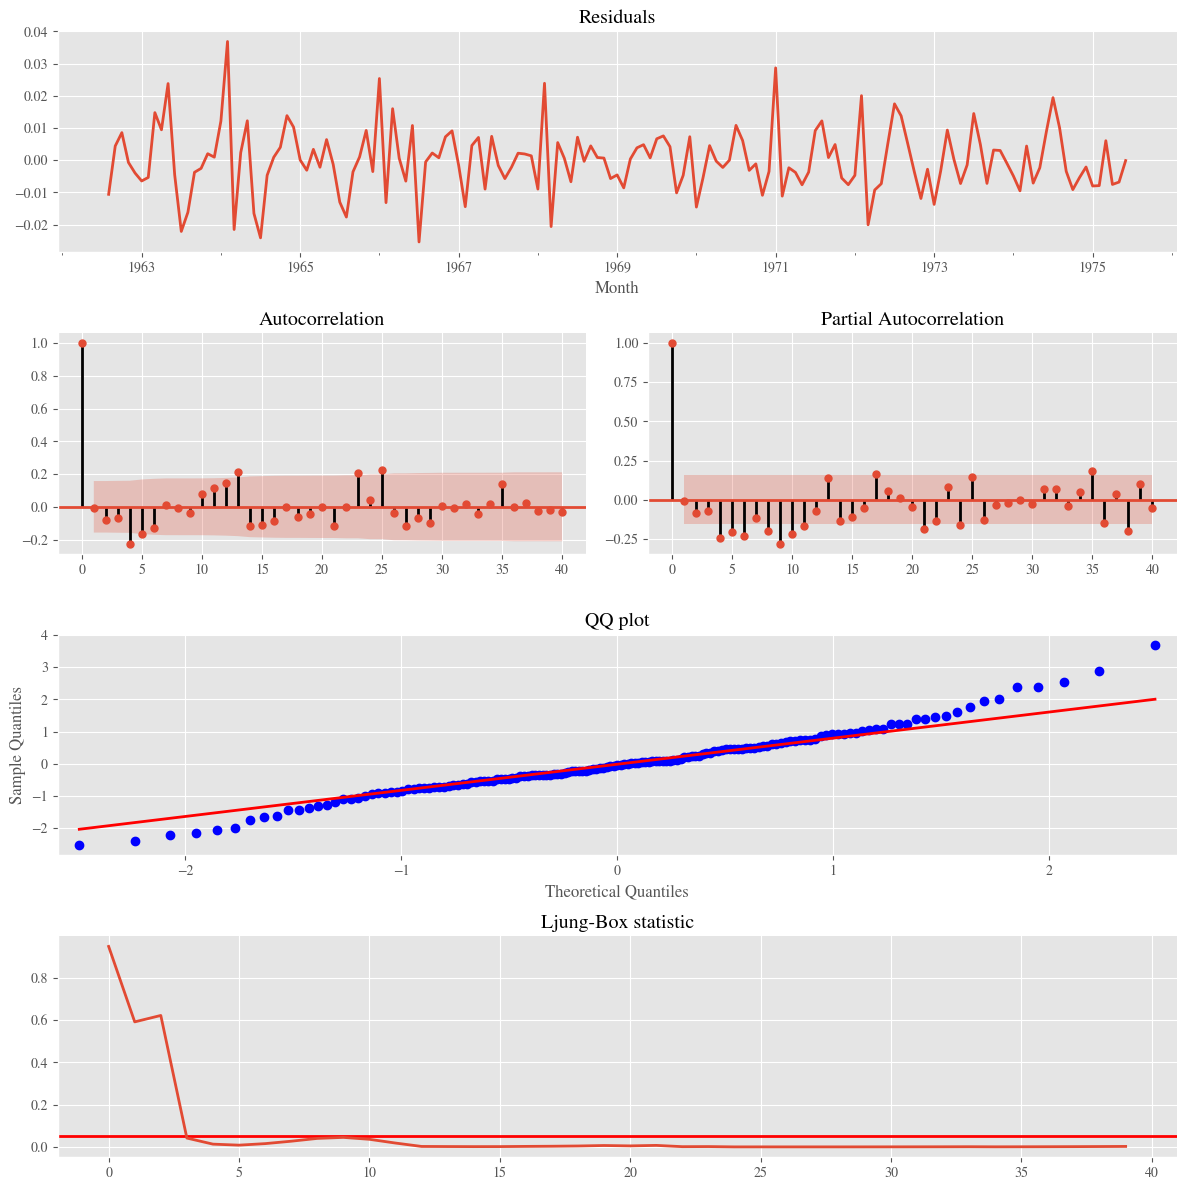

In [60]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

Let's fit a seasonal ARIMA model to the milk production data

From the [documentation examples on the Statsmodels package](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb), we have the following explanation:

Specifying the model in Statsmodels is done simply by adding the `seasonal_order` argument, which accepts a tuple of the form `(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)`. The seasonal AR and MA specifications, as before, can be expressed as a maximum polynomial degree or as the lag polynomial itself. Seasonal periodicity is an integer.

For the log milk production model ARIMA $(2,1,0) \times (1,1,0)_{12}$ with an intercept, the command is:

`mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(2,1,0), seasonal_order=(1,1,0,12)`


/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:              D.DS12.log_production   No. Observations:                  154
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 481.378
Date:                            Sat, 06 Oct 2018   AIC                           -954.756
Time:                                    19:30:02   BIC                           -942.609
Sample:                                03-01-1963   HQIC                          -949.822
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0385      0.556     -0.069      0.945      -1.127       1.050
ma.L1         -0.1133      0.553   

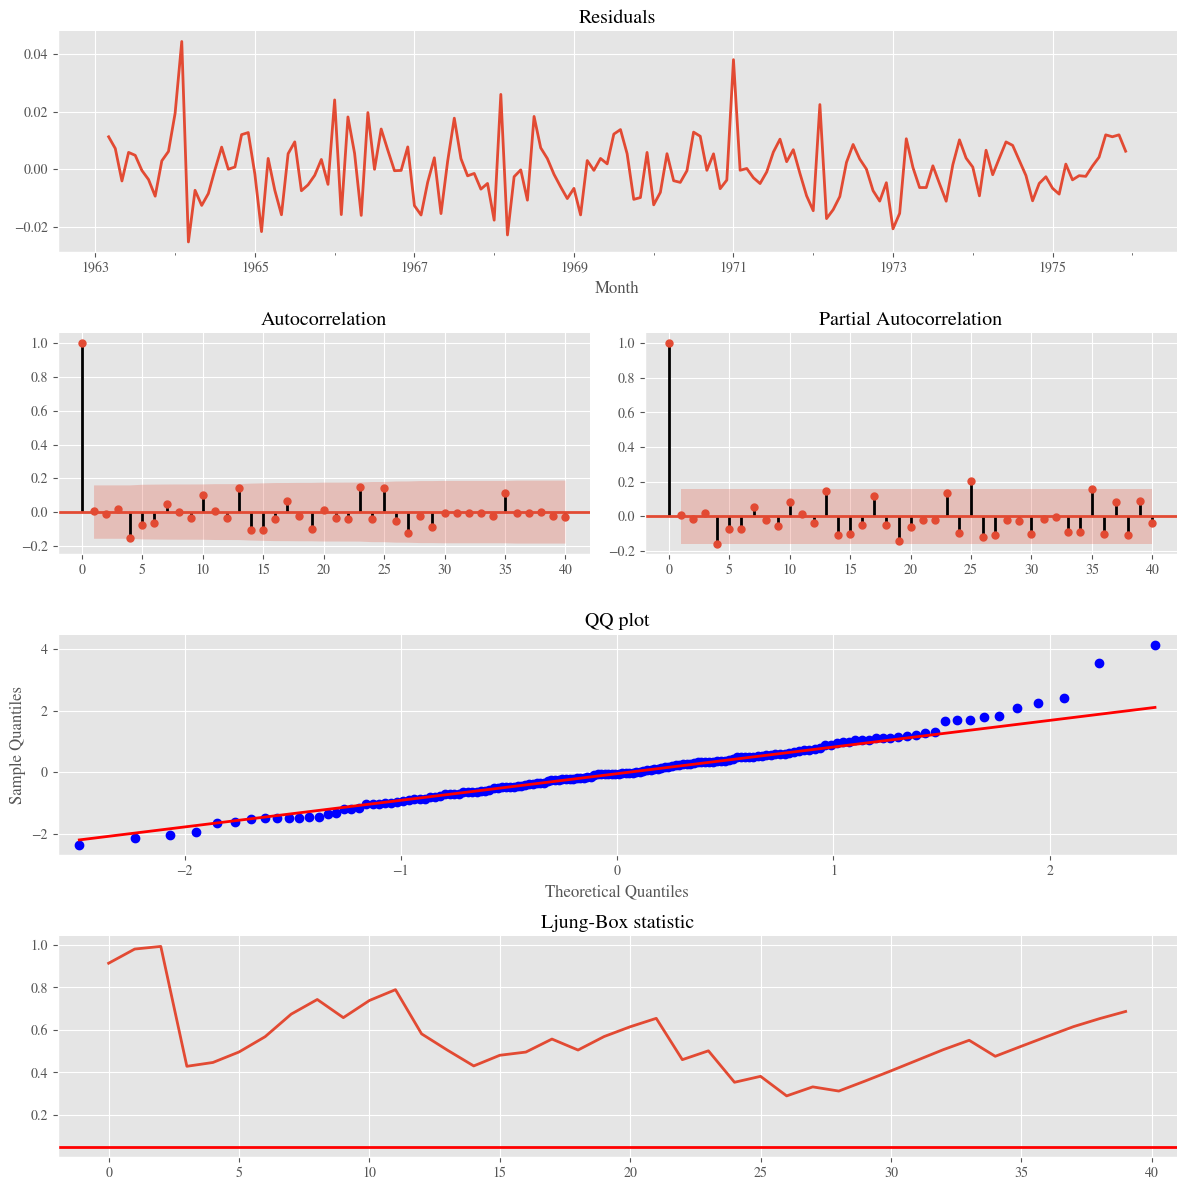

In [61]:
# Fit an ARIMA model to the log of milk production  
# We don't need to difference since we can specify the differencing in the Statsmodels method

# An alternative method in statsmodel - no seasonality
#mod = smt.ARIMA(milk['log_production'], order=(0,1,1))  

#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(0,1,1), simple_differencing=True)

# Non-seasonal and seasonal differencing, MA only on the non-seasonal part
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(0,1,1), seasonal_order=(0,1,0,12), simple_differencing=True)

# Do this to add MA term to the seasonal part 
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(0,1,1), seasonal_order=(0,1,1,12), simple_differencing=True)

# Add another MA term - MA(2) on seasonal part
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(0,1,1), seasonal_order=(0,1,2,12), simple_differencing=True)

# AR(1) term on the non-seasonal part 
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(1,1,0), seasonal_order=(0,1,0,12), simple_differencing=True)

# AR(2) term on the non-seasonal part
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(2,1,0), seasonal_order=(0,1,0,12), simple_differencing=True)

# AR(1) term on both the non-seasonal and seasonal part 
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(1,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)

# AR(2) term on the non-seasonal part and AR(1) term on the seasonal part 
#mod = sm.tsa.statespace.SARIMAX(milk['log_production'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)

# SARIMA (1,1,1)x(0,1,2)12
mod = smt.SARIMAX(milk['log_production'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), simple_differencing=True)

results_ARIMA = mod.fit()
print (results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

##  The "Airline Data"

Dataset Series G of Chapter 9 of Box, Jenkins and Reinsel "Time Series Analysis, Forecasting and Control", Third Edition.
  - The classical example for showing the identification of seasonal models

In [62]:
flights = sns.load_dataset("flights")
flights.head()

year     month  passengers
0  1949   January         112
1  1949  February         118
2  1949     March         132
3  1949     April         129
4  1949       May         121

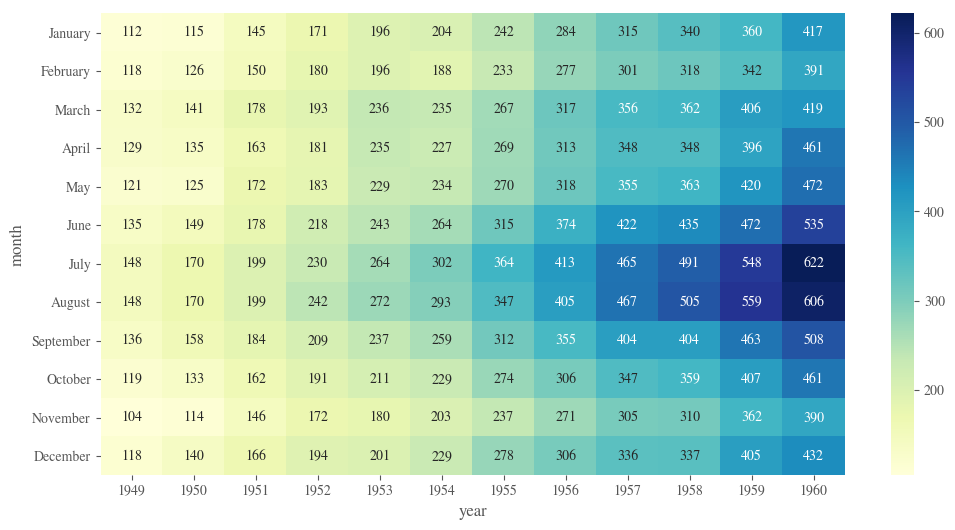

In [63]:
pivot = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")

In [64]:
flights.index = pd.date_range(start=datetime(flights.year[0], 1, 1), periods=len(flights), freq='MS')
flights.head()

year     month  passengers
1949-01-01  1949   January         112
1949-02-01  1949  February         118
1949-03-01  1949     March         132
1949-04-01  1949     April         129
1949-05-01  1949       May         121

In [65]:
flights['log_passengers'] = np.log(flights['passengers'])
flights['log_passengers_diff']= flights['log_passengers'].diff()
flights.dropna(inplace=True)
flights.head()

year     month  passengers  log_passengers  log_passengers_diff
1949-02-01  1949  February         118        4.770685             0.052186
1949-03-01  1949     March         132        4.882802             0.112117
1949-04-01  1949     April         129        4.859812            -0.022990
1949-05-01  1949       May         121        4.795791            -0.064022
1949-06-01  1949      June         135        4.905275             0.109484

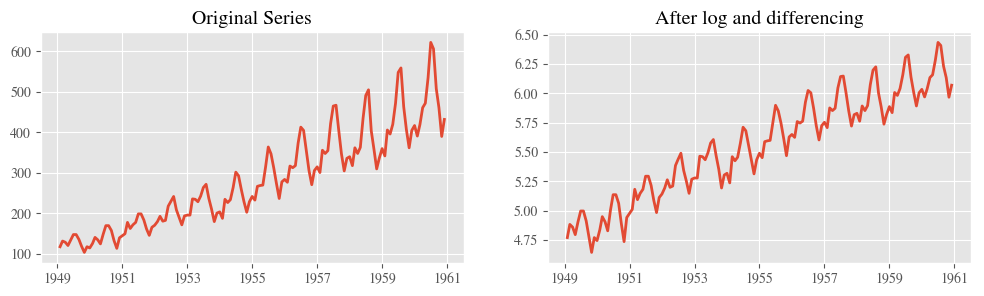

In [66]:
#Plot the data
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(flights['passengers']);
ax[0].set_title('Original Series')
#ax[1].plot(flights['log_passengers_diff']);
ax[1].plot(flights['log_passengers']);
ax[1].set_title('After log and differencing');

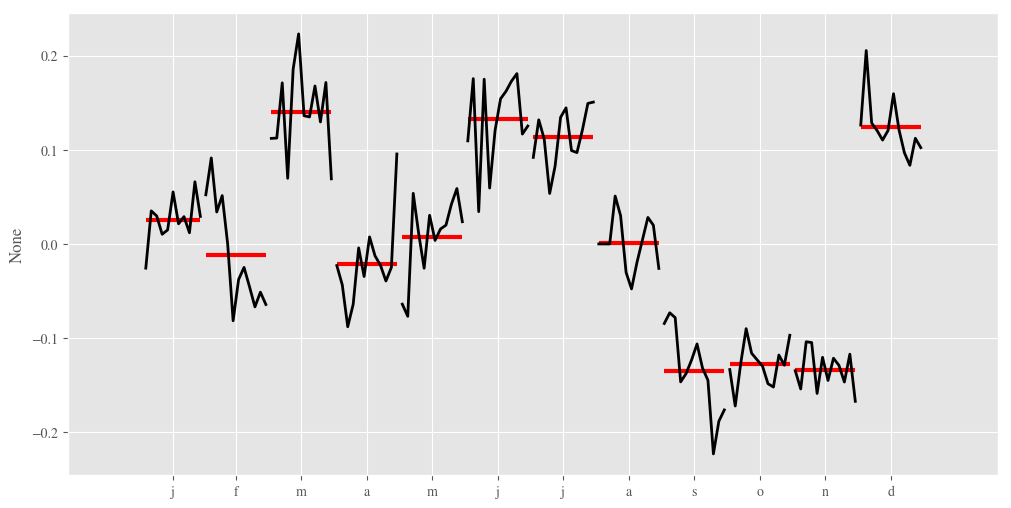

In [67]:
_ = smg.tsa.month_plot(flights['log_passengers_diff'])

## Seasonal Decomposition

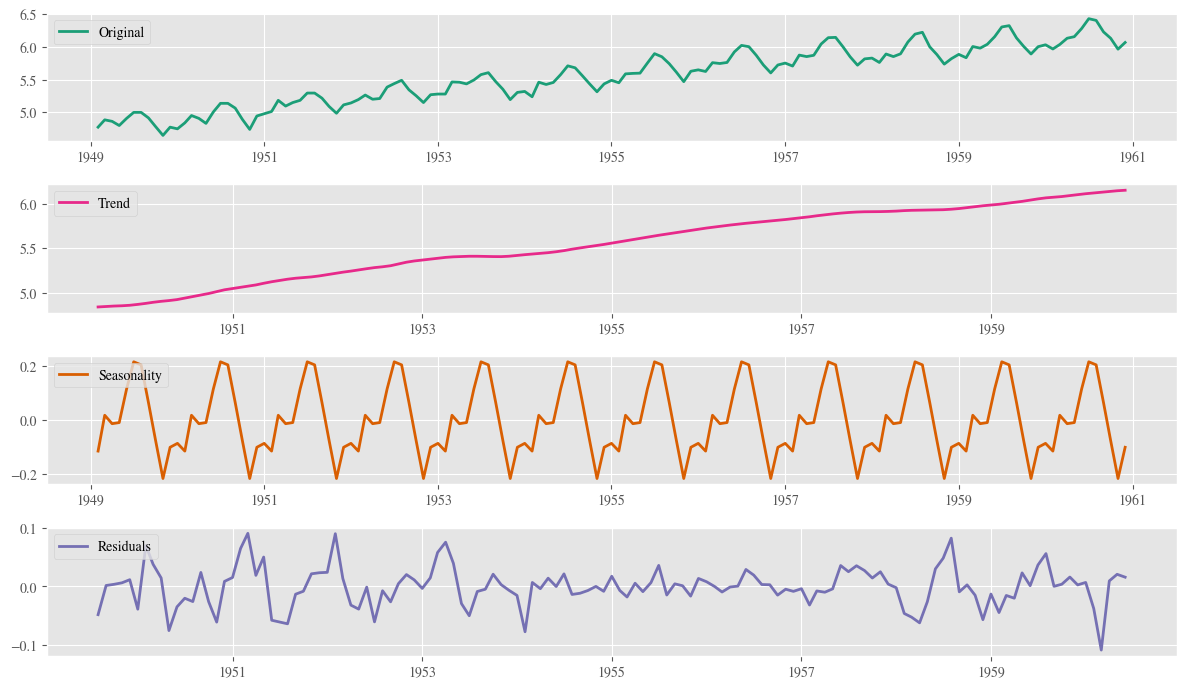

In [68]:
## plot out the components of the time series
decomposition = breakout_plots(flights['log_passengers']) # try both data['passengers'] and  data['log_passengers_diff']

### Let's plot the first-differenced series again and look at the ACF and PACF plots

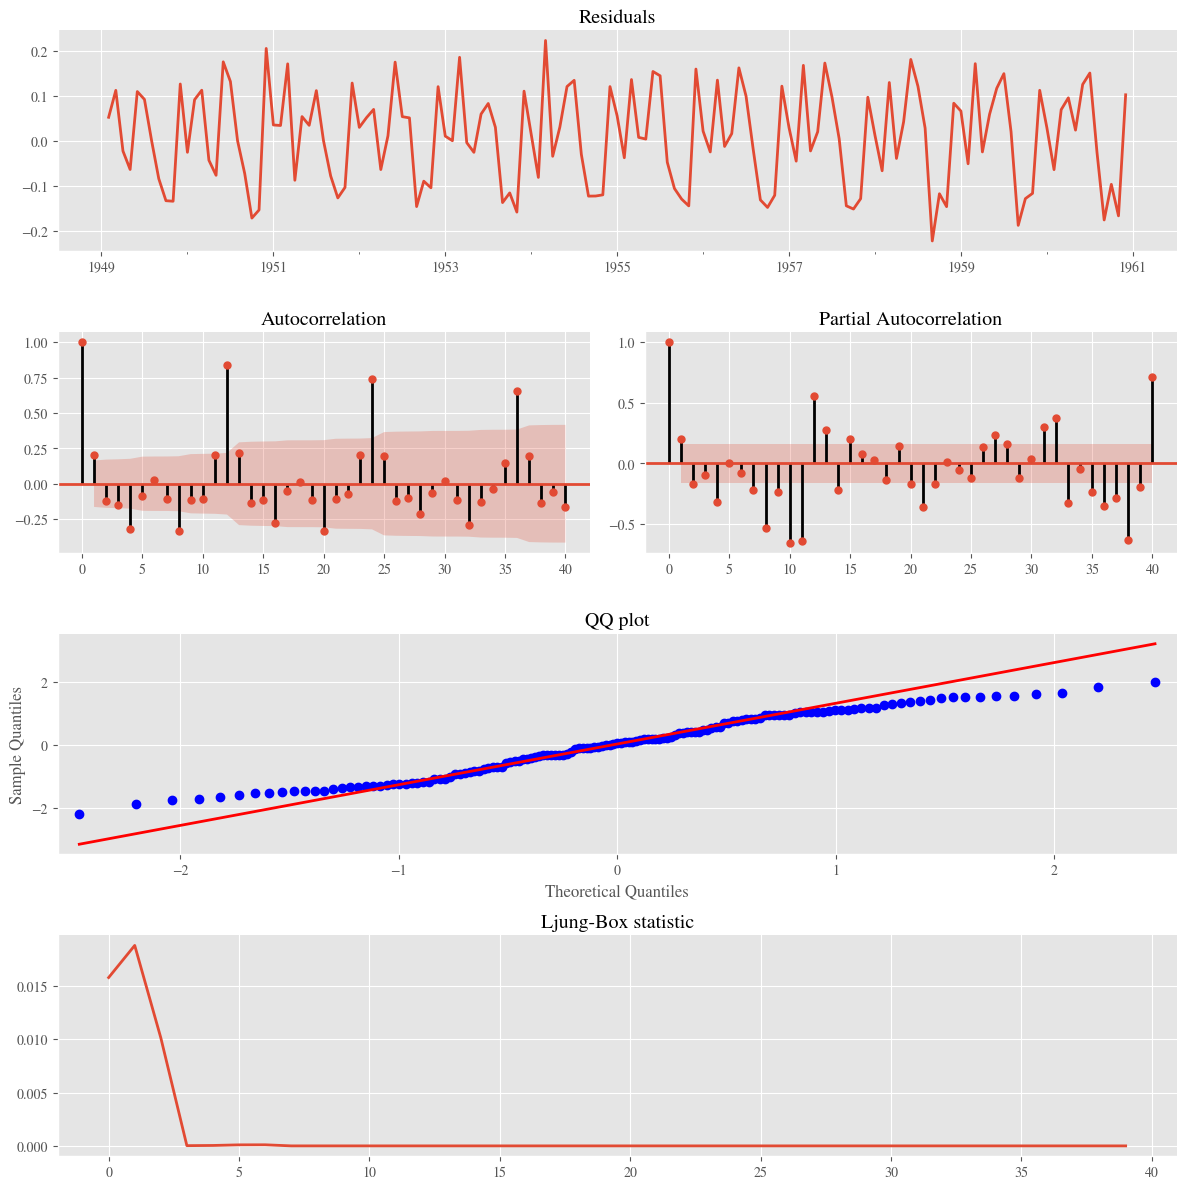

In [69]:
_ = tsplot(flights['log_passengers_diff'], 40)

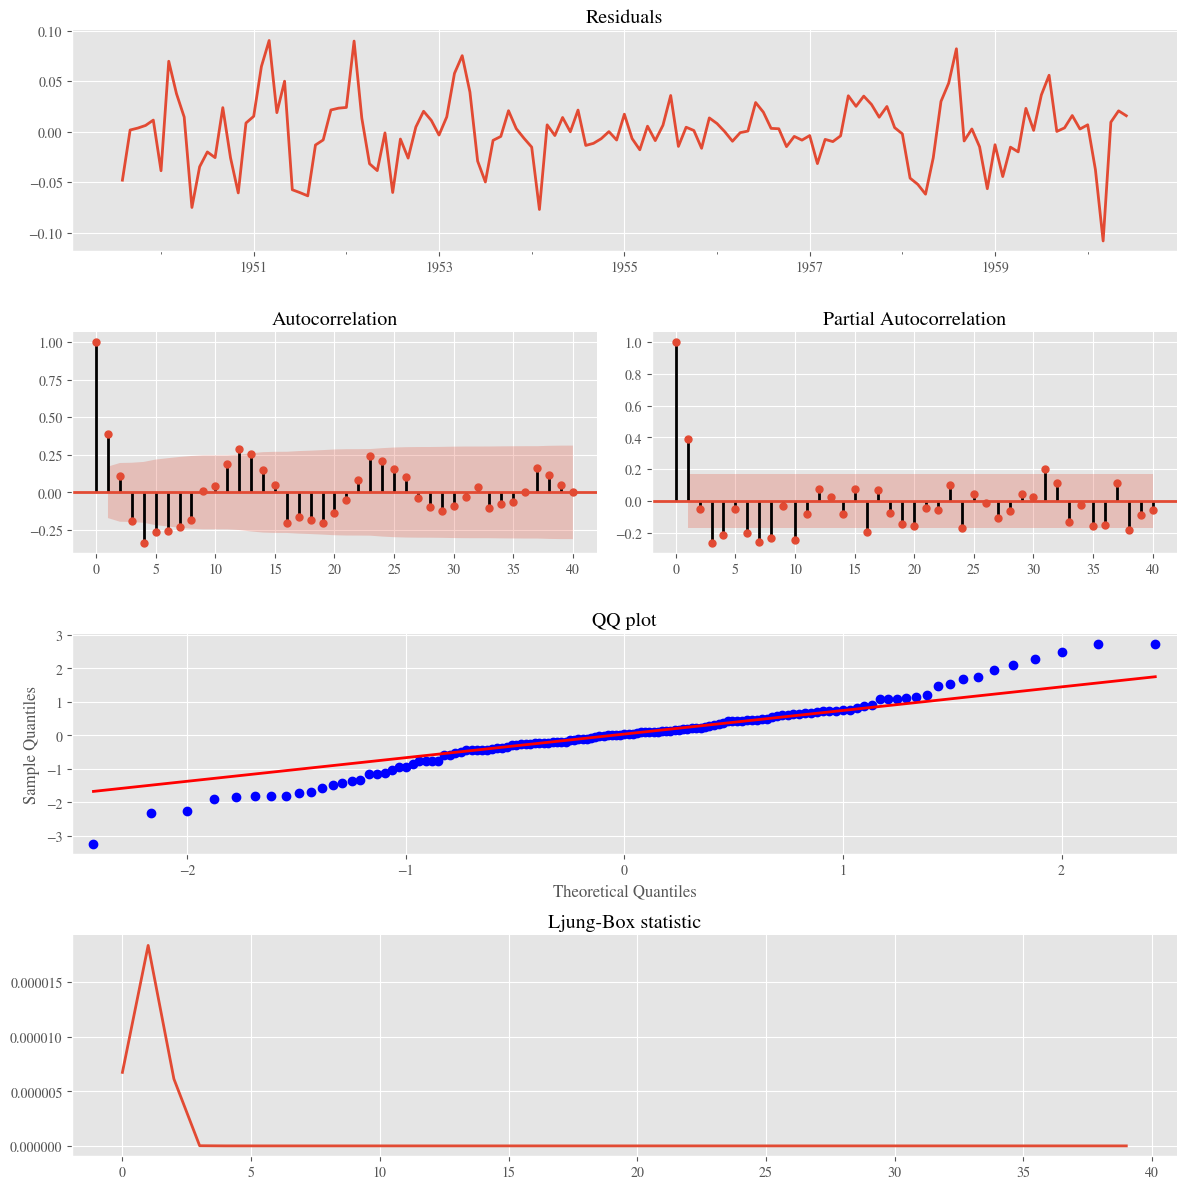

In [70]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

### SARIMA (p,d,q)x(P,D,Q)

Explanations from [here](https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/statespace_sarimax_stata.ipynb) 


The data process can be written generically as:

$$
\phi_p (L) \tilde \phi_P (L^s) \Delta^d \Delta_s^D y_t = A(t) + \theta_q (L) \tilde \theta_Q (L^s) \epsilon_t
$$

where:

- $\phi_p (L)$ is the non-seasonal autoregressive lag polynomial
- $\tilde \phi_P (L^s)$ is the seasonal autoregressive lag polynomial
- $\Delta^d \Delta_s^D y_t$ is the time series, differenced $d$ times, and seasonally differenced $D$ times.
- $A(t)$ is the trend polynomial (including the intercept)
- $\theta_q (L)$ is the non-seasonal moving average lag polynomial
- $\tilde \theta_Q (L^s)$ is the seasonal moving average lag polynomial

sometimes we rewrite this as:

$$
\phi_p (L) \tilde \phi_P (L^s) y_t^* = A(t) + \theta_q (L) \tilde \theta_Q (L^s) \epsilon_t
$$

where $y_t^* = \Delta^d \Delta_s^D y_t$. This emphasizes that just as in the simple case, after we take differences (here both non-seasonal and seasonal) to make the data stationary, the resulting model is just an ARMA model.

As an example, consider the airline model ARIMA $(2,1,0) \times (1,1,0)_{12}$, with an intercept. The data process can be written in the form above as:

$$
(1 - \phi_1 L - \phi_2 L^2) (1 - \tilde \phi_1 L^{12}) \Delta \Delta_{12} y_t = c + \epsilon_t
$$

Here, we have:

- $\phi_p (L) = (1 - \phi_1 L - \phi_2 L^2)$
- $\tilde \phi_P (L^s) = (1 - \phi_1 L^12)$
- $d = 1, D = 1, s=12$ indicating that $y_t^*$ is derived from $y_t$ by taking first-differences and then taking 12-th differences.
- $A(t) = c$ is the *constant* trend polynomial (i.e. just an intercept)
- $\theta_q (L) = \tilde \theta_Q (L^s) = 1$ (i.e. there is no moving average effect))

It may still be confusing to see the two lag polynomials in front of the time-series variable, but notice that we can multiply the lag polynomials together to get the following model:

$$
(1 - \phi_1 L - \phi_2 L^2 - \tilde \phi_1 L^{12} + \phi_1 \tilde \phi_1 L^{13} + \phi_2 \tilde \phi_1 L^{14} ) y_t^* = c + \epsilon_t
$$

which can be rewritten as:

$$
y_t^* = c + \phi_1 y_{t-1}^* + \phi_2 y_{t-2}^* + \tilde \phi_1 y_{t-12}^* - \phi_1 \tilde \phi_1 y_{t-13}^* - \phi_2 \tilde \phi_1 y_{t-14}^* + \epsilon_t
$$

This is similar to the additively seasonal model from example 2, but the coefficients in front of the autoregressive lags are actually combinations of the underlying seasonal and non-seasonal parameters.

                                 Statespace Model Results                                 
Dep. Variable:              D.DS12.log_passengers   No. Observations:                  130
Model:             SARIMAX(0, 0, 1)x(0, 0, 2, 12)   Log Likelihood                 242.609
Date:                            Sat, 06 Oct 2018   AIC                           -477.219
Time:                                    19:30:06   BIC                           -465.749
Sample:                                03-01-1950   HQIC                          -472.558
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4169      0.074     -5.669      0.000      -0.561      -0.273
ma.S.L12      -0.5950      0.096   

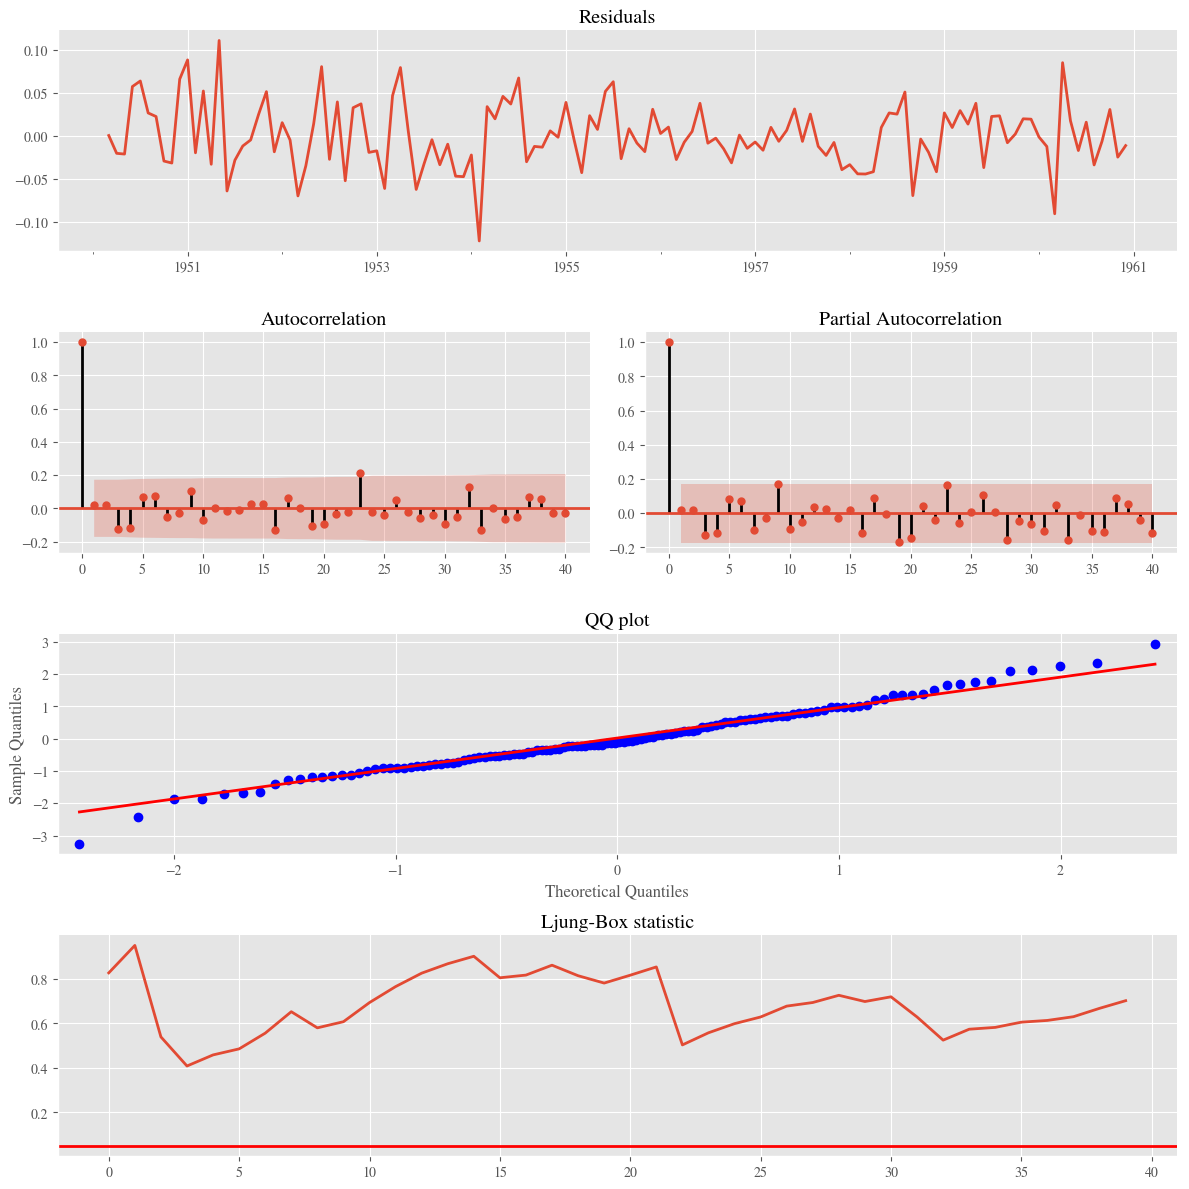

In [71]:
# Fit an ARIMA model to the log of air passengers

#mod = sm.tsa.statespace.SARIMAX(flights['log_passengers'], order=(0,1,1), simple_differencing=True)
#mod = sm.tsa.statespace.SARIMAX(flights['log_passengers'], order=(0,1,1), seasonal_order=(0,1,0,12), simple_differencing=True)
#mod = sm.tsa.statespace.SARIMAX(flights['log_passengers'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)#mod = sm.tsa.statespace.SARIMAX(flights['log_passengers'], order=(0,1,1), seasonal_order=(0,1,1,12), simple_differencing=True)
mod = sm.tsa.statespace.SARIMAX(flights['log_passengers'], order=(0,1,1), seasonal_order=(0,1,2,12), simple_differencing=True)
#mod = smt.SARIMAX(flights['log_passengers'], order=(0,1,1), seasonal_order=(0,1,1,12))
#mod = smt.SARIMAX(flights['log_passengers'], order=(0, 1, 1), seasonal_order=(0, 1, 2, 12))

results_ARIMA = mod.fit()
print (results_ARIMA.summary())

_ = tsplot(results_ARIMA.resid, 40)

### What is this `simple_differencing=True` ?


Notice that here we used an additional argument simple_differencing=True. This controls how the order of integration is handled in ARIMA models. If simple_differencing=True, then the time series provided as endog is literatlly differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata's arima always uses simple differencing) or if the seasonal periodicity is large.

The default is simple_differencing=False, in which case the integration component is implemented as part of the state space formulation, and all of the original data can be used in estimation.

<a id='Time-Series-Forecasting'></a>


Forecasting time series
=====

[Back to top](#top)


## [Examples](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

### The Sunspots dataset from Section 4 - with an ARIMA model with pdq (0,1,1) 

In [72]:
sunspots = sm.datasets.sunspots.load_pandas().data
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del sunspots["YEAR"]

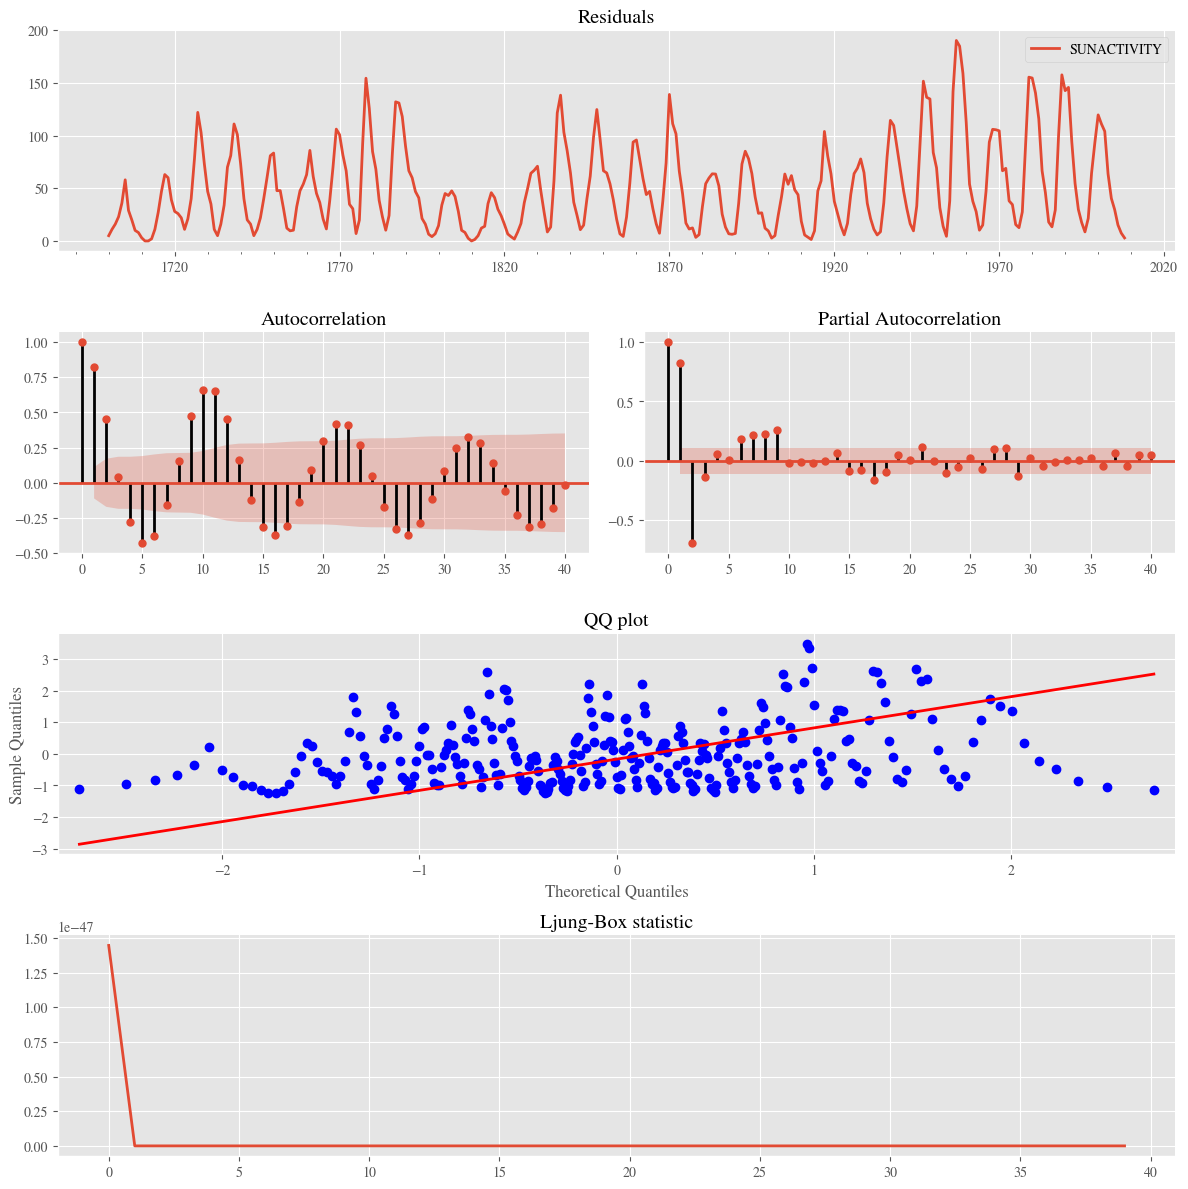

In [73]:
_ = tsplot(sunspots, 40)

In [74]:
results_ARIMA = ARIMA(sunspots.SUNACTIVITY, order=(3,0,3)).fit(disp=-1)    #2,0,2  #4,0,4 #3,0,3 #2,1,2

/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


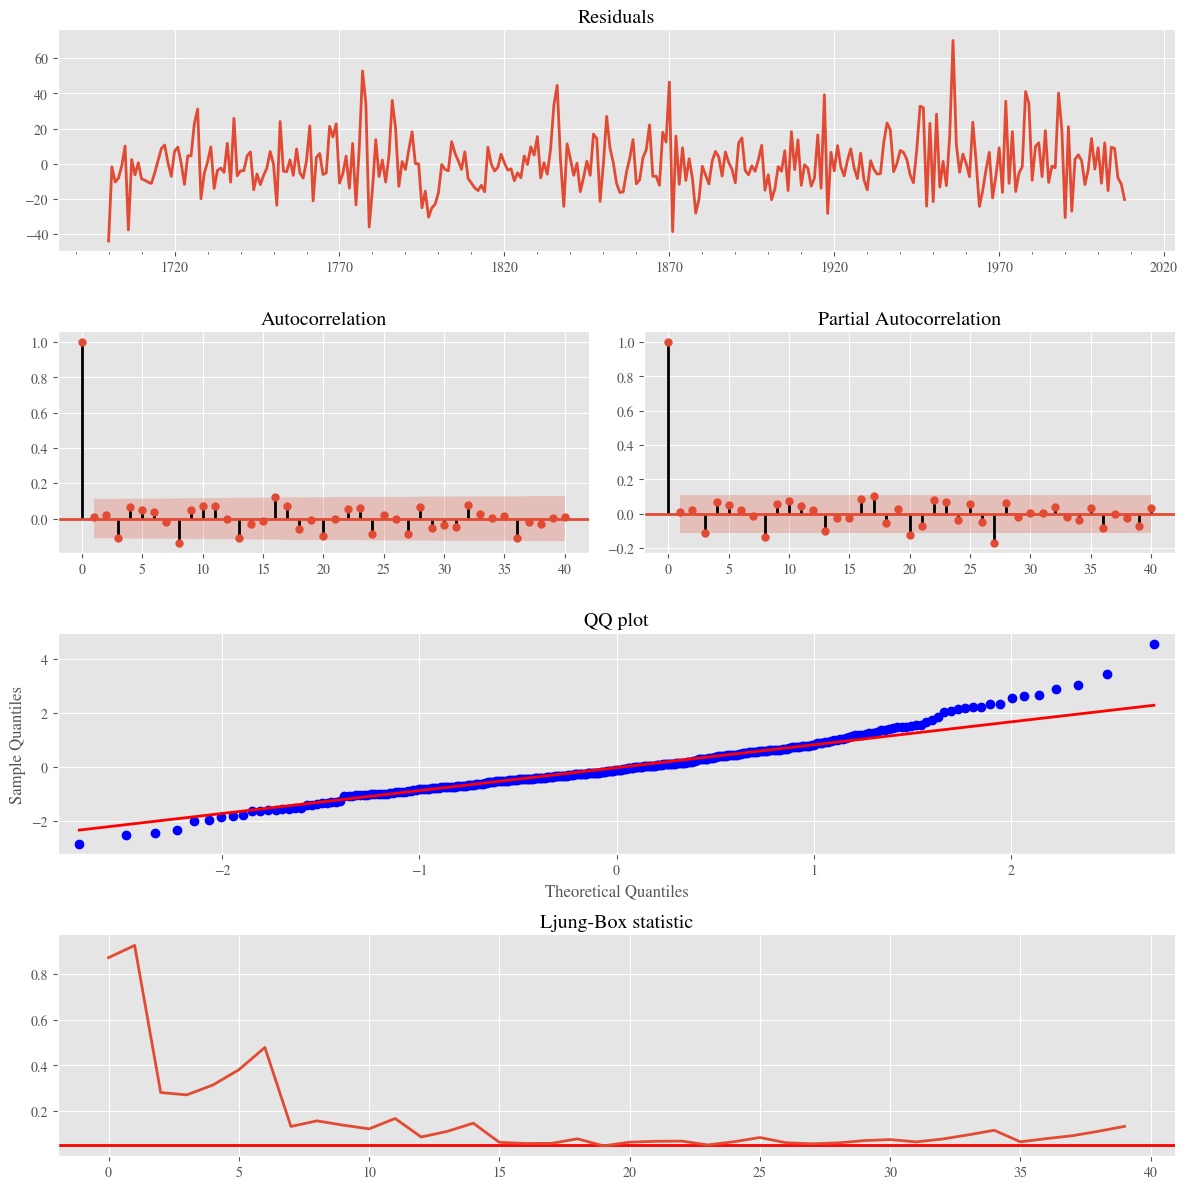

In [75]:
_ = tsplot(results_ARIMA.resid, 40)

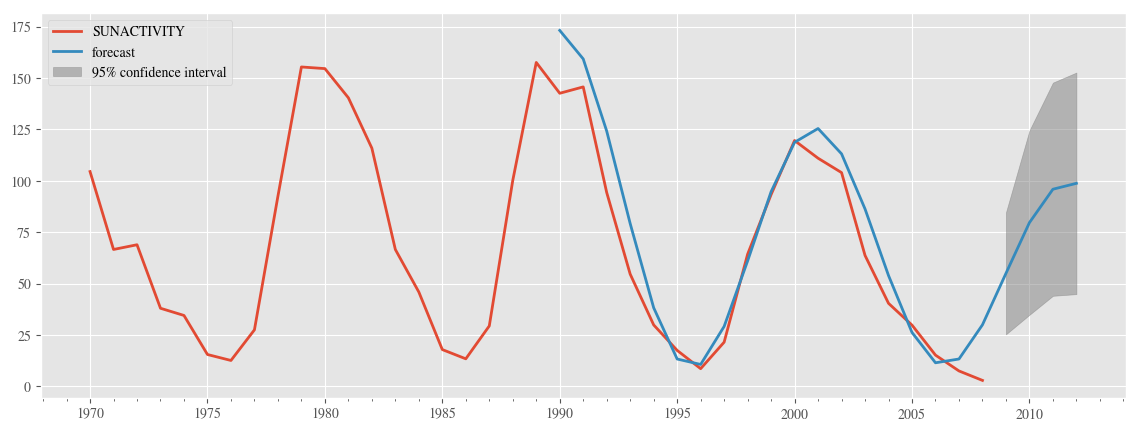

In [76]:
fig, ax = plt.subplots(figsize=(14, 5))
ax = sunspots['1970':].plot(ax=ax)
fig = results_ARIMA.plot_predict('1990-12-31', '2012-12-31', dynamic=True, ax=ax, plot_insample=False)
legend = ax.legend(loc='upper left')

In [77]:
def root_mean_forecast_err(y, yhat):
    return np.sqrt(np.mean((y.sub(yhat))**2))

predict_sunspots = results_ARIMA.predict('1990', '2008', dynamic=True)
root_mean_forecast_err(sunspots.SUNACTIVITY, predict_sunspots)

15.493111647387261

## Forecasting the Air Passenger Data series - with a SARIMA model -  pdq = (0,1,1) PDQ(0,1,1,12)

### First with a simple ARIMA model -  pdq = (0,1,1) 

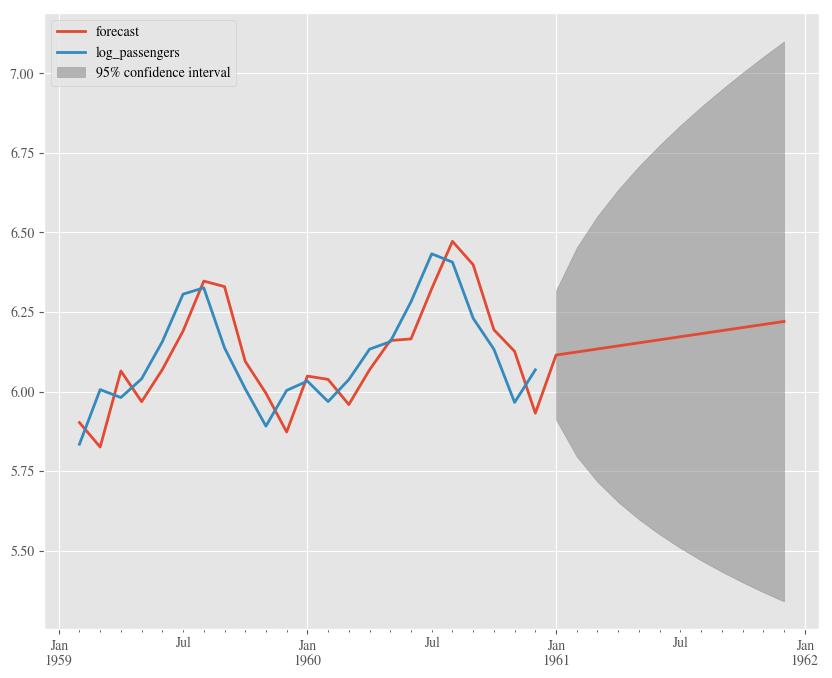

In [78]:
results_ARIMA = sm.tsa.ARIMA(flights.log_passengers, order=(0,1,1)).fit()

fig, ax = plt.subplots(figsize=(10,8))
#fig = results_ARIMA.plot_predict(start = '1959-02-01', end= '1961-12-01', dynamic=True , ax=ax)
fig = results_ARIMA.plot_predict(start = '1959-02-01', end= '1961-12-01',  ax=ax)
legend = ax.legend(loc='upper left')

###  Then with a SARIMA model -  pdq = (0,1,1,)   PDQ(0,1,1,12)

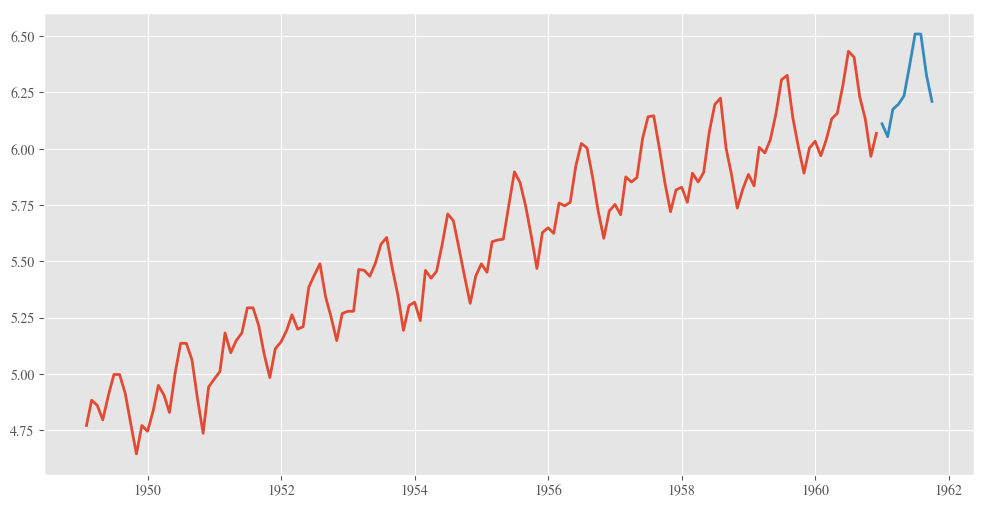

In [79]:
results_ARIMA = sm.tsa.SARIMAX(flights.log_passengers, order=(0,1,1), seasonal_order=(0,1,2,12)).fit()
pred = results_ARIMA.forecast(steps=10, dynamic= True)  
plt.plot(flights.log_passengers)
plt.plot(pred);

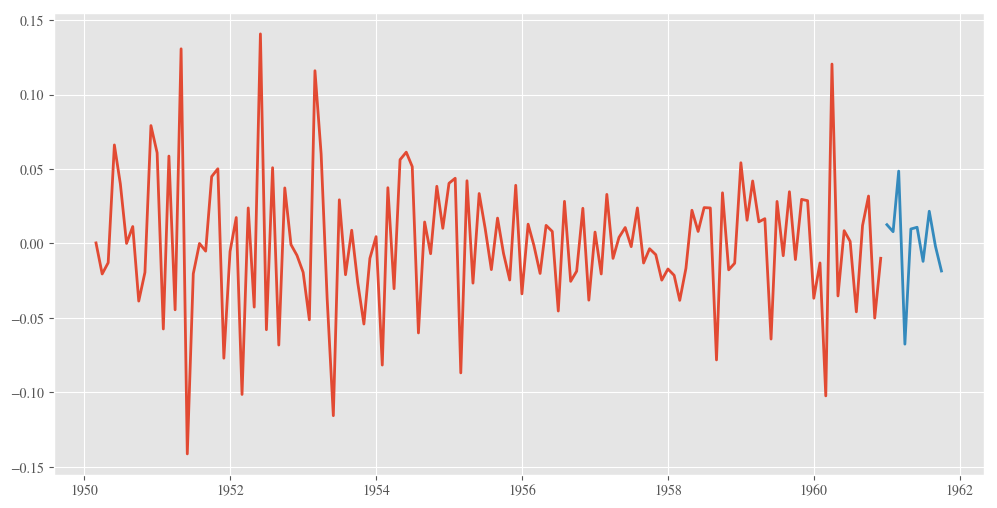

In [80]:
results_ARIMA = smt.SARIMAX(flights.log_passengers, order=(0,1,1), seasonal_order=(0,1,1,12), simple_differencing=True).fit()
pred = results_ARIMA.forecast(steps=10, dynamic= True)  
shifted = lambda x: x - x.shift(-1) - x.shift(-12) + x.shift(-13)

plt.plot(shifted(flights.log_passengers).shift(13))
plt.plot(pred);

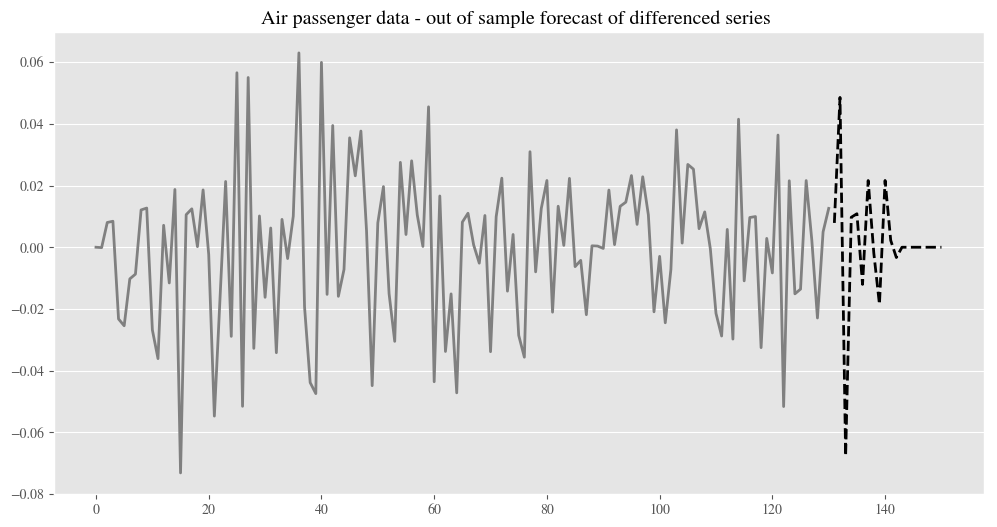

In [81]:
#  From the example notebook of Chad Fulton
# http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_internet.html

# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 20
predict = results_ARIMA.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)

ax.set(title='Air passenger data - out of sample forecast of differenced series ');

Another famous dataset - the Canadian lynx data
======

Let's plot it out with the plotting that we define above for residuals

In [82]:
url = "https://s3.amazonaws.com/csci-e82-section-data/lynx.csv"
lynx = pd.read_csv(url, header = 0, parse_dates = [1], names = ['idx', 'trapped'], index_col = 1)
lynx.drop('idx', inplace=True, axis=1)
lynx['trapped'] = np.log(lynx['trapped'].astype(float))
lynx.head()

trapped
1821-01-01  5.594711
1822-01-01  5.771441
1823-01-01  6.371612
1824-01-01  6.769642
1825-01-01  7.296413

/Users/dave/Applications/anaconda/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


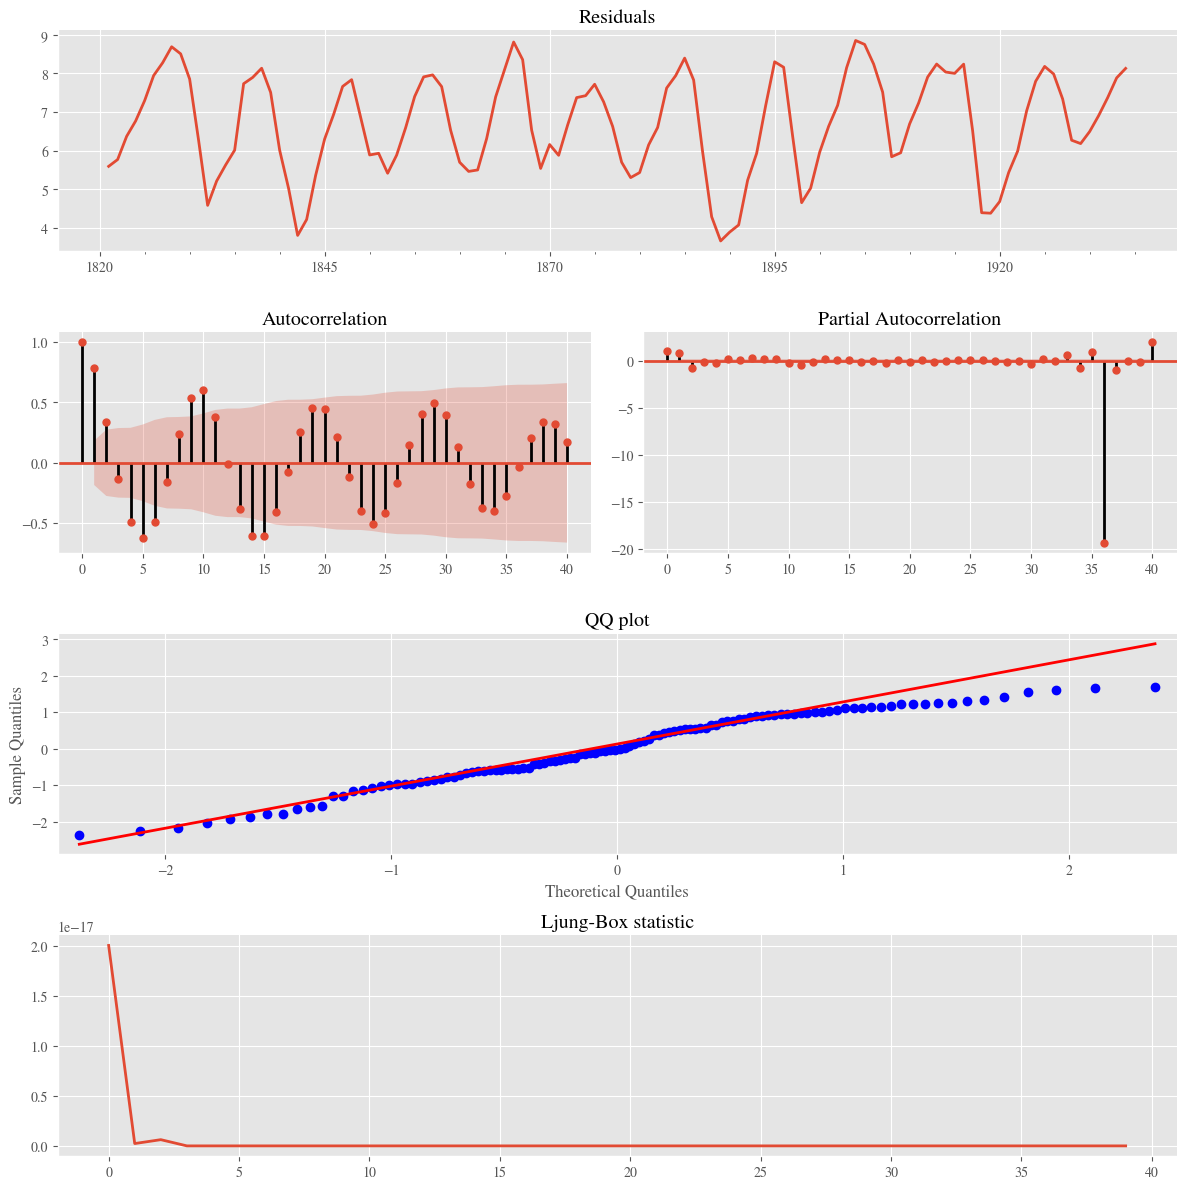

In [83]:
_ = tsplot(lynx['trapped'], 40)

In [84]:
#results = smt.ARIMA(lynx['trapped'], order=(11,0,0), freq='AS').fit(trend = 'nc')
results = smt.ARIMA(lynx['trapped'], order=(2,0,0), freq='AS').fit(trend = 'c')
print (results.summary())
print(results.aic)
print(results.bic)

                              ARMA Model Results                              
Dep. Variable:                trapped   No. Observations:                  114
Model:                     ARMA(2, 0)   Log Likelihood                 -88.575
Method:                       css-mle   S.D. of innovations              0.520
Date:                Sat, 06 Oct 2018   AIC                            185.150
Time:                        19:30:12   BIC                            196.095
Sample:                    01-01-1821   HQIC                           189.592
                         - 01-01-1934                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.6863      0.135     49.578      0.000       6.422       6.951
ar.L1.trapped     1.3776      0.061     22.426      0.000       1.257       1.498
ar.L2.trapped    -0.7399      0.061    -

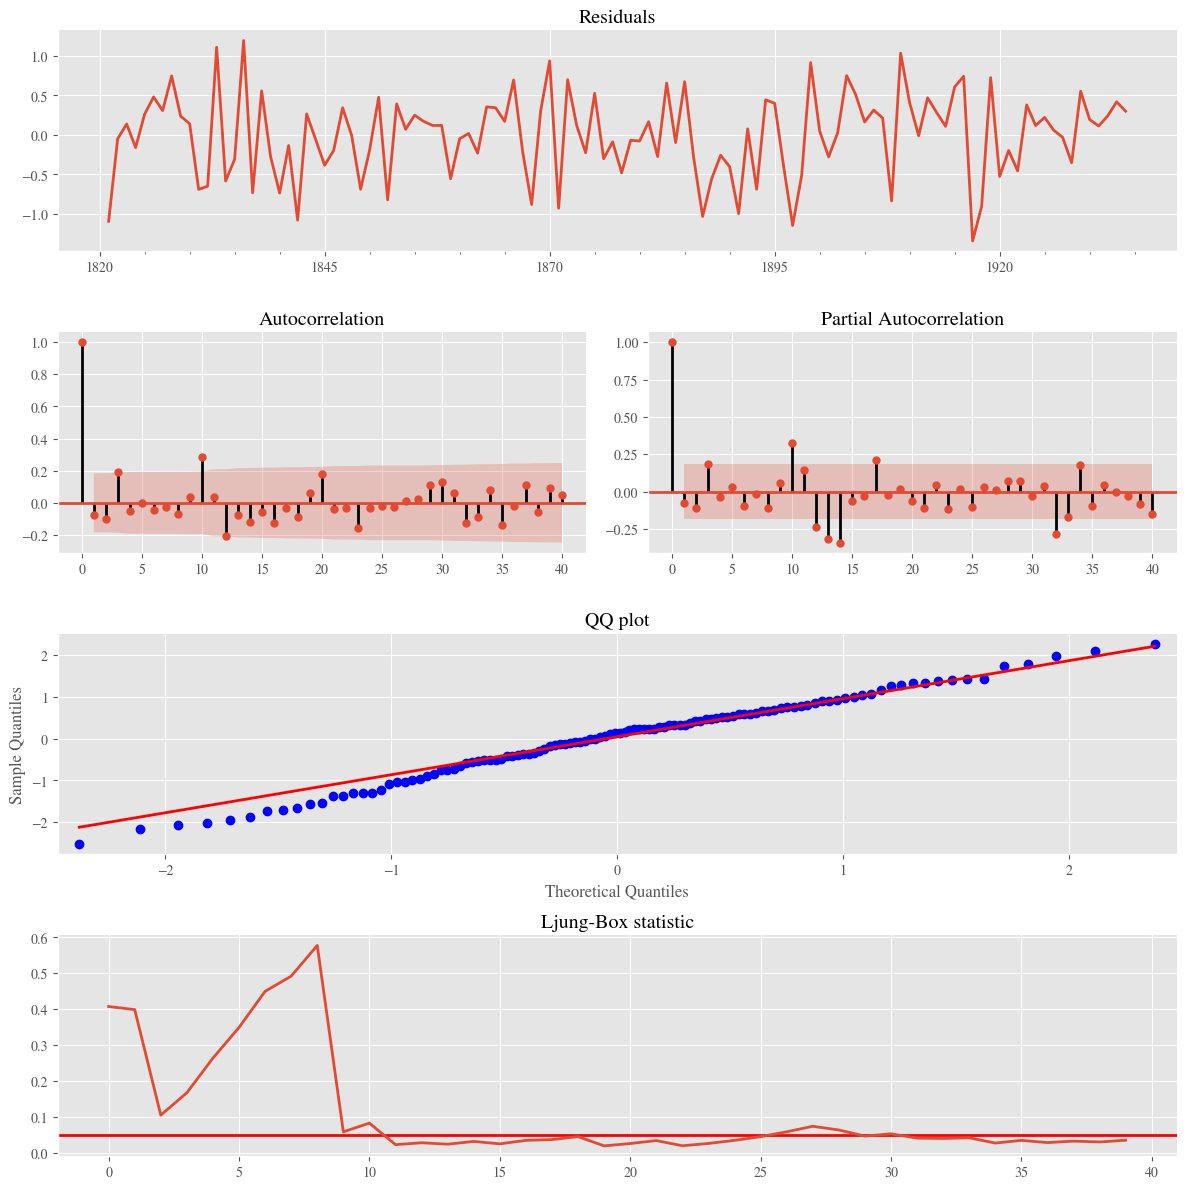

In [85]:
_ = tsplot(results.resid, 40)

### History -
Moran (1953) fitted an AR(2) model with an intercept, but found that one-step prediction was not good.  Tong (1977) looked at many models, and arrived at an AR(11) model without an intercept.  

Actually, the data have a cycle of about 10 years - but not always - sometimes 9 years, sometimes 11 years.

- How can we look at the cyclical nature of a series?

In [86]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()

EXTRA - to look at at your leisure...
=======

<a id='Frequency-domain-analysis'></a>


Frequency domain analysis
=====

[Back to top](#top)

Frequency, or spectral, analysis is a distinct, but complementary path of analysis - based on characterizing the time series as a periodic signal, and analyzing the properties of that signal. The ultimate reference for this is the text (actually, two volumes) by Priestley "Spectral Analysis and Time Series".  Spectral analysis is simply an alternative representation of the autocovariance function time series that is covariance stationary.

Let's look at the idea with a purely periodic signal, and the Discrete Fourier Transform (DFT), which converts the series in the time domain to the frequency domain.  

$$ f(t) = \sin (10 \cdot 2 \cdot \pi \cdot t) $$

Here $10$ is the frequency of the signal - the number of cycles per second (Hertz) - so we are generating a series that cycles 10 times a second. Alternatively, we can think of the period - 1 /  frequency - as the "repeat" in the signal. In our example, the period is 1/10 seconds.

Last - in order to plot our continuous signal, we need to sample it. So, we choose a sampling rate, $100$, which just means measure the signal 100 times a second. 

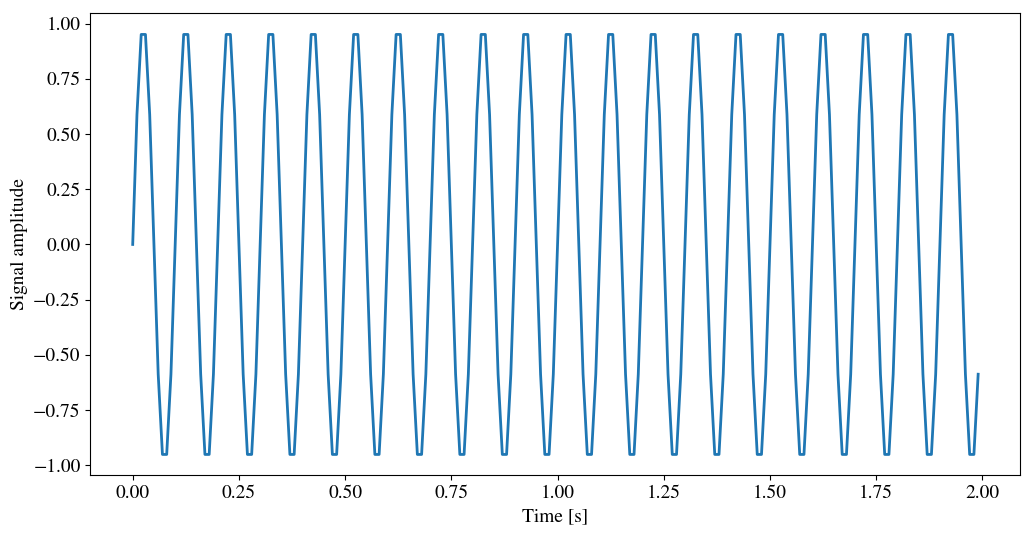

In [87]:
frequency = 10  
sampling_rate = 100 

t = np.linspace(0, 2, 2 * sampling_rate, endpoint=False)
x = np.sin(frequency * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

(-5, 110)

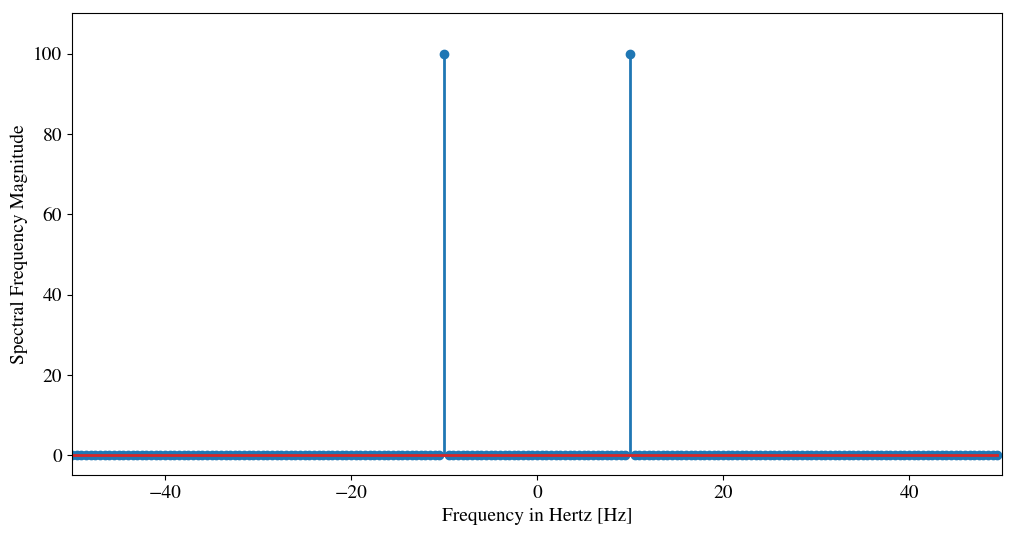

In [88]:
from scipy import fftpack

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * sampling_rate

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Spectral Frequency Magnitude')
ax.set_xlim(-sampling_rate / 2, sampling_rate / 2)
ax.set_ylim(-5, 110)

## The periodogram

From [Penn state Time series course](https://onlinecourses.science.psu.edu/stat510/node/80):


**
... the periodogram, a function/graph that displays information about the periodic components of a time series.  Any time series can be expressed as a sum of cosine and sine waves oscillating at the fundamental (harmonic) frequencies = j/n, with j = 1, 2, …, n/2.  The periodogram gives information about the relative strengths of the various frequencies for explaining the variation in the time series.  **

**The periodogram is a sample estimate of a population function called the spectral density, which is a frequency domain characterization of a population stationary time series.  The spectral density is a frequency domain representation of a time series that is directly related to the autocovariance time domain representation.  In essence the spectral density and the autocovariance function contain the same information, but express it in different ways. **


Also:
[Thomas Sargents site](https://lectures.quantecon.org/py/estspec.html)

### The 'raw' periodogram - i.e. no smoothing


(200,)


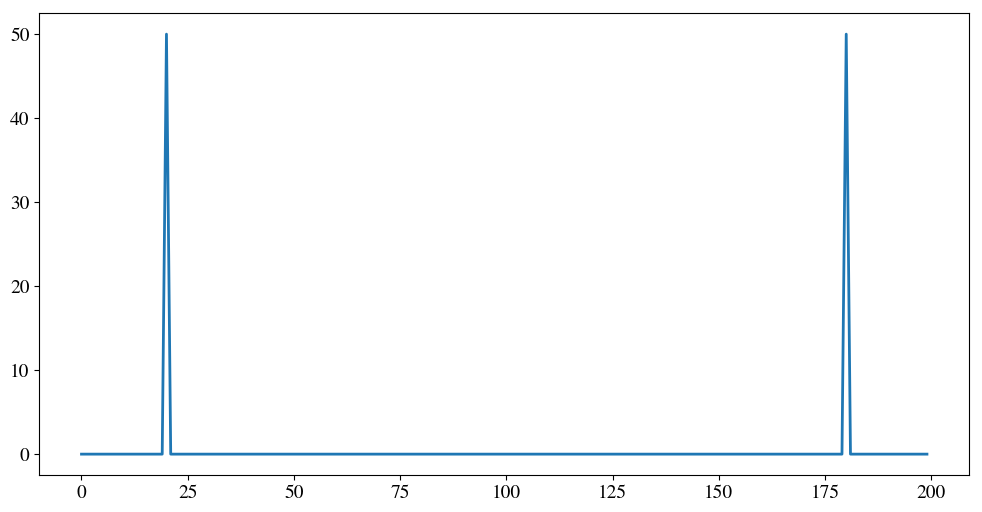

In [89]:
# periodogramme = lambda X: 1./len(X) * np.abs(np.fft.fft(X))**2
# freqs = np.abs(np.fft.fft(X))**2 / len(X)

pgram = periodogram(x)
print(pgram.shape)
plt.plot(pgram)

### Let's look at the frequency domain characteristics of the Lynx data

Text(0,0.5,'Spectral Frequency Magnitude')

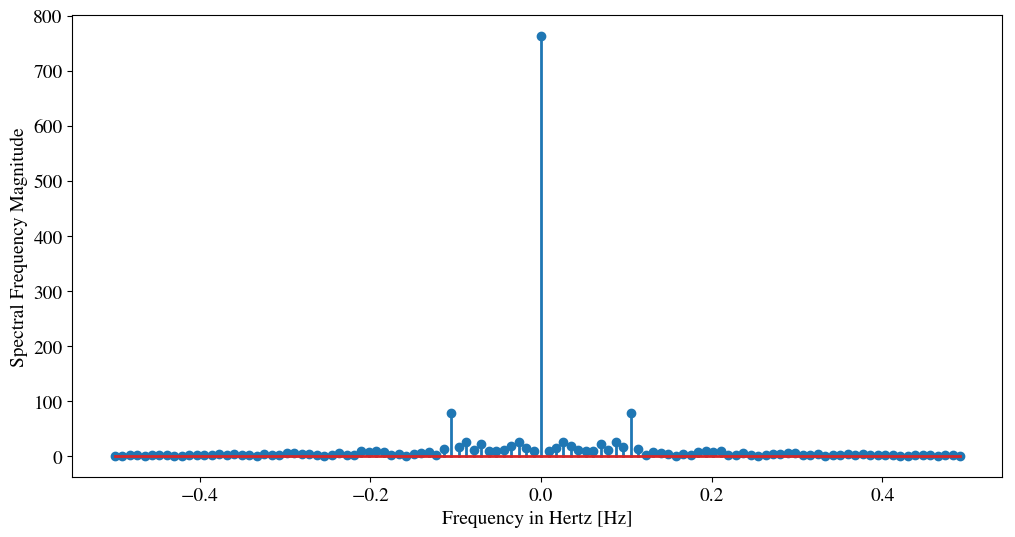

In [90]:
X = fftpack.fft(lynx['trapped'])
freqs = fftpack.fftfreq(len(lynx['trapped'])) 

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Spectral Frequency Magnitude')

(114,)


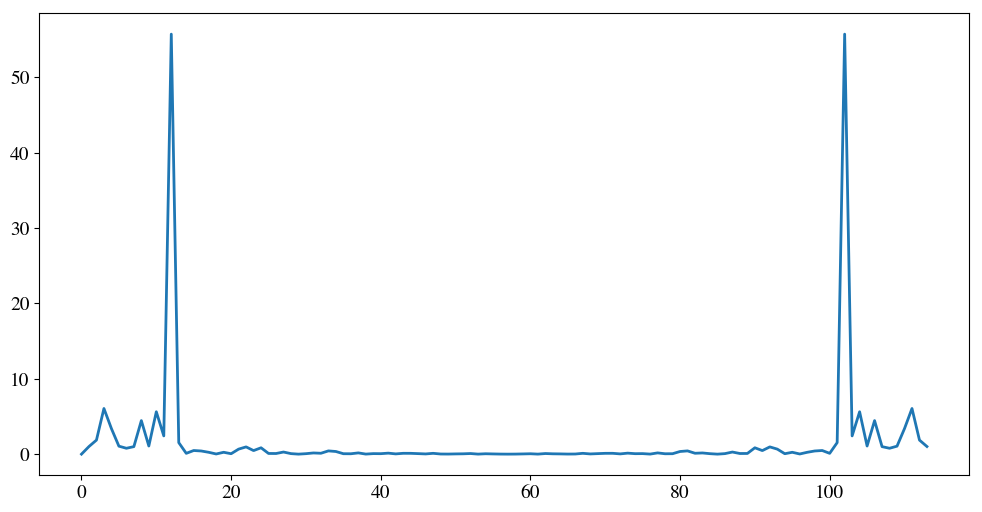

In [91]:
pgram = periodogram(lynx['trapped'])
print(pgram.shape)
plt.plot(pgram)

### Now let's generate an ARMA (2,0) process and see how it compares to the Lynx dataset

- series plot
- ACF, PACF
- QQ plot
- Ljung box

- Periodogram

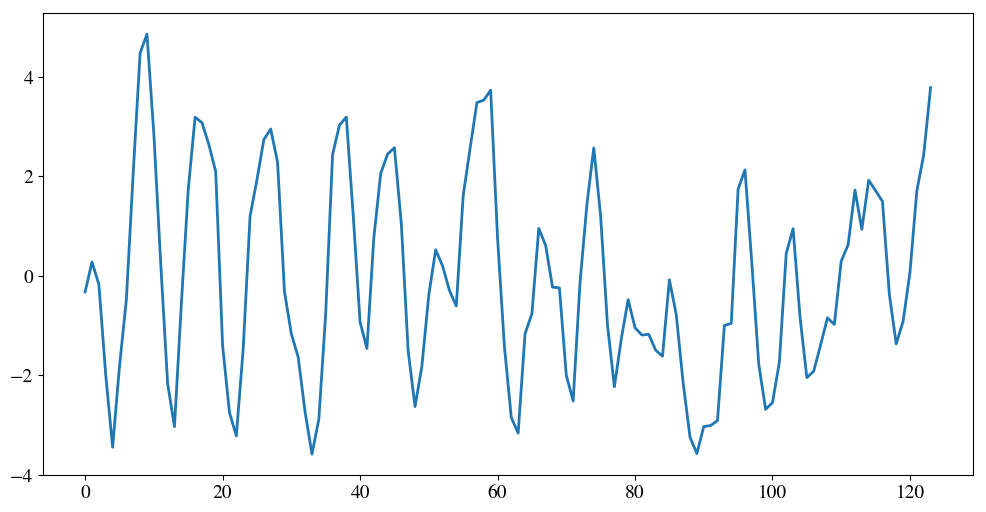

In [92]:
from statsmodels.tsa.arima_process import arma_generate_sample
arparams = np.r_[1, -np.array([1.38, -0.74])]
maparams = np.r_[1 ]

y = arma_generate_sample(arparams, maparams, 124)
plt.plot (y)

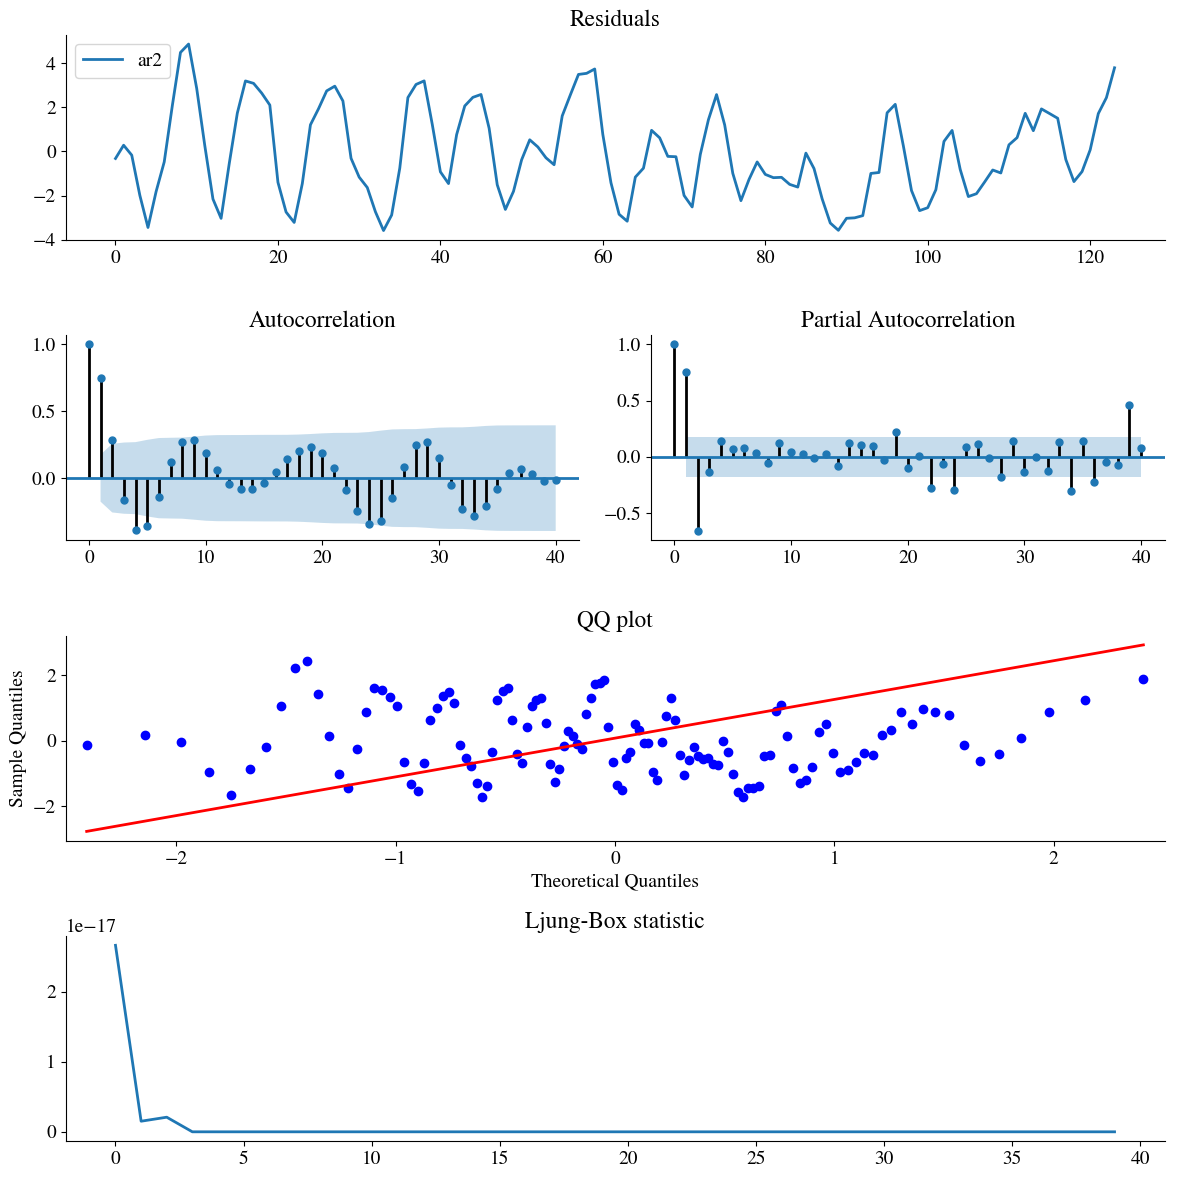

In [93]:
gendata = pd.DataFrame({'ar2':y})
_ = tsplot(gendata, 40)

In [94]:
#results = smt.ARIMA(lynx['trapped'], order=(2,0,0)).fit(trend = 'c')
results = smt.ARIMA(y, order=(2,0,0)).fit(trend = 'c')
print (results.summary())
print (results.aic)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  124
Model:                     ARMA(2, 0)   Log Likelihood                -172.974
Method:                       css-mle   S.D. of innovations              0.968
Date:                Sat, 06 Oct 2018   AIC                            353.949
Time:                        19:30:15   BIC                            365.230
Sample:                             0   HQIC                           358.532
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0668      0.220     -0.303      0.762      -0.498       0.365
ar.L1.y        1.2819      0.066     19.474      0.000       1.153       1.411
ar.L2.y       -0.6773      0.066    -10.315      0.0

(124,)


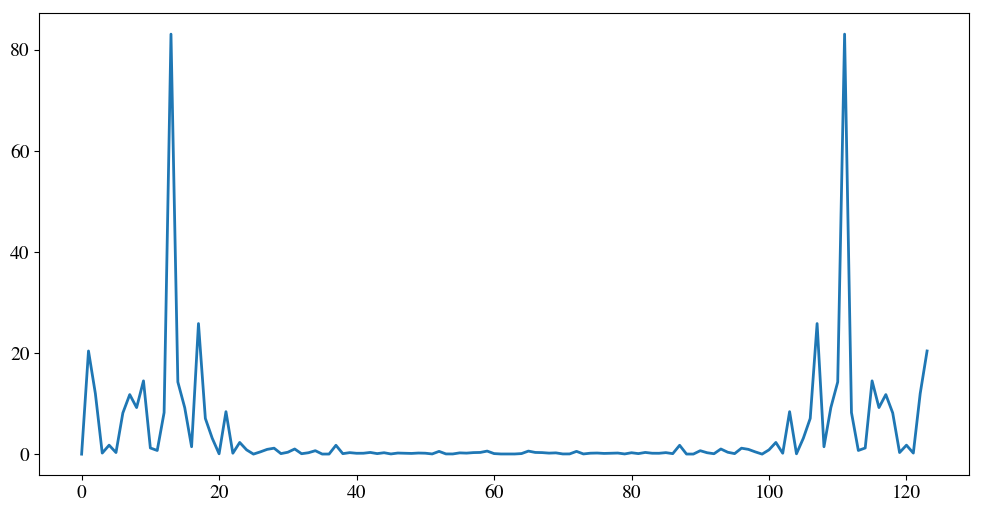

In [95]:
pgram = periodogram(y)
print(pgram.shape)
plt.plot(pgram)

<a id='Dynamic-time-warping'></a>


Dynamic Time Warping (DTW)
=====

[Back to top](#top)


based on the work of Pierre Rouanet  https://pypi.python.org/pypi/dtw/1.0

before running this example you need to install dtw   

`pip install dtw`

## DTW

The Dynamic Time Warping (DTW) distance measure is a technique that has long been known in speech recognition community.  It allows a non-linear mapping of one signal to another by minimizing the distance between the two.  A decade ago, DTW was introduced into Data Mining community as a utility for various tasks for time series problems including classification, clustering, and anomaly detection. The technique has flourished, particularly in the last three years, and has been applied to a variety of problems in various disciplines. 

## A simple example with two generated time series

In [96]:
x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0, 4, 4, 0, -4, 0]).reshape(-1, 1)
y = np.array([1, 1, 1, 2, 2, 2, 2, 3, 2, 0, 1, 3, 4, 3, 1, -1, -2, -1, 0, 2]).reshape(-1, 1)

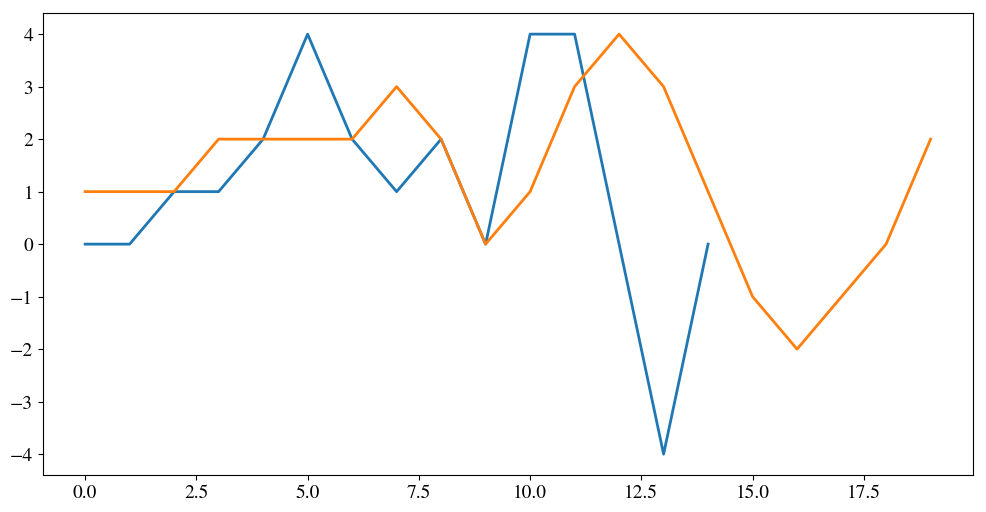

In [97]:
plt.plot(x)
plt.plot(y)

## Compute DTW

The `dtw()` function returns the distance, the cost, the accumulated cost and the shortest cost path

In [98]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [99]:
print ('Minimum distance found:', dist)
#print ('Cost matrix for path:\n', cost)
#print ('Accumulated cost matrix:\n', acc)

Minimum distance found: 0.4


## Use imshow to plot the accumulated cost matrix and a line corresponding to the shortest cost path.

(-0.5, 19.5)

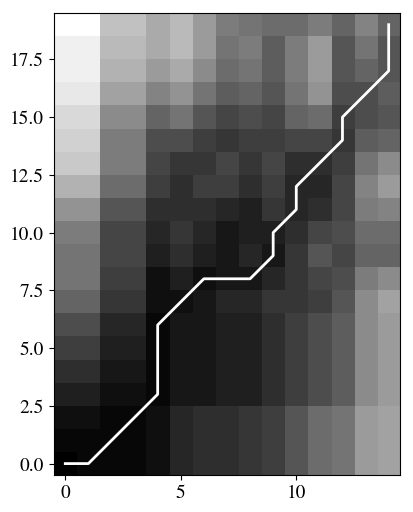

In [100]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"), interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

In [101]:
x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0, 4, 3, 0, -2, -1, -3, 0, 1, 2, 1, 2,3, 2, 3, 4, 2, 0, 1, 3, 4, 3, 1, -1, -2, -1, 0, 2]).reshape(-1, 1)
y = np.array([ 1, 2,3, 2, 3, 4, 2, 0, 1, 3, 4, 3, 1, -1, -2, -1, 0, 2]).reshape(-1, 1)


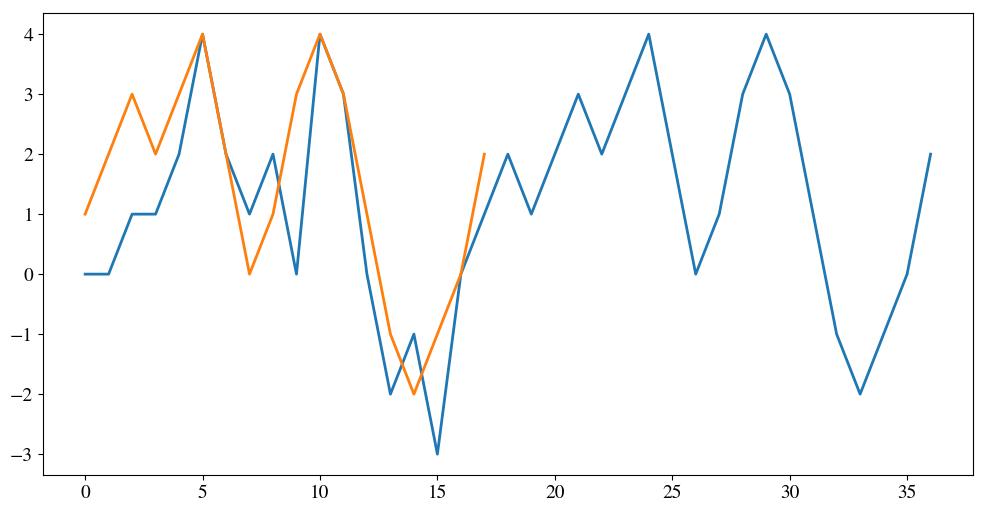

In [102]:
plt.plot(x)
plt.plot(y)

## Compute DTW

The `dtw()` function returns the distance, the cost, the accumulated cost and the shortest cost path

In [103]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [104]:
print ('Minimum distance found:', dist)
#print ('Cost matrix for path:\n', cost)
#print ('Accumulated cost matrix:\n', acc)

Minimum distance found: 0.43636363636363634


## Use imshow to plot the accumulated cost matrix and a line corresponding to the shortest cost path.

(-0.5, 17.5)

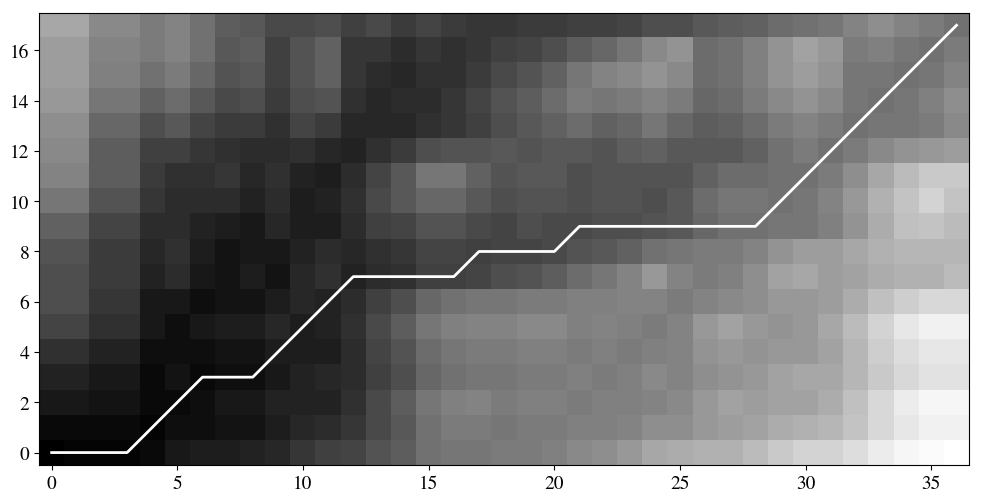

In [105]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"), interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

## Using another distance

You can specify your own distance used as the cost measure by the DTW. By default the L1 norm is used.

In [106]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: (x * x) + (y * y))

(-0.5, 17.5)

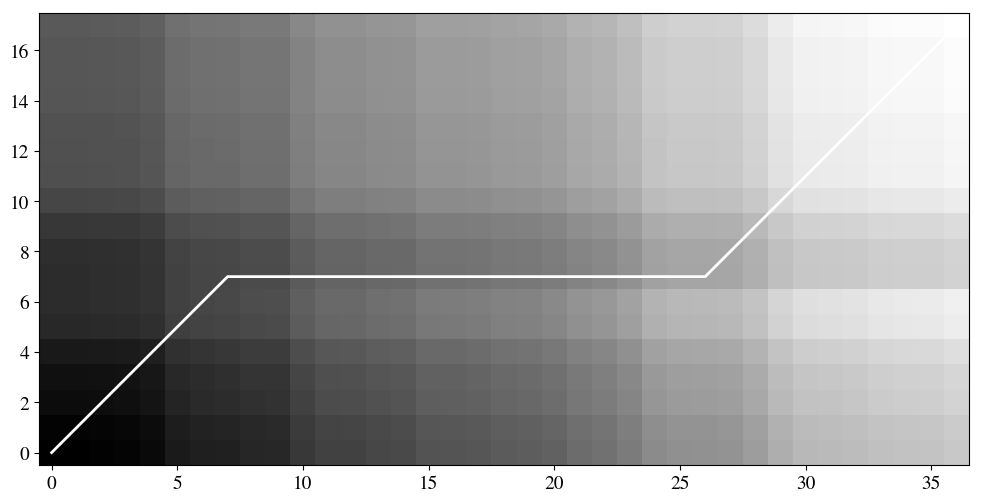

In [107]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"), interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

## Detecting subsequences  
The sequences used can be of different length. DTW can also be useful to detect subsequences.

In [108]:
y = [0] * 2 + x
#y =  [[0]*2] + y + [[0]*2]
y = np.array(y).reshape(-1, 1)

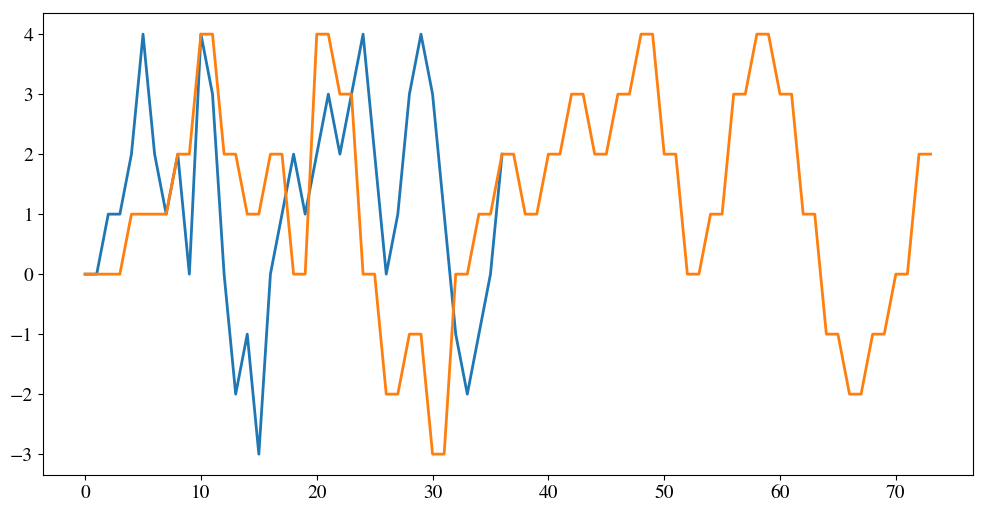

In [109]:
plt.plot(x)
plt.plot(y)

In [110]:
dist, cost, acc, path = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [111]:
print ('Minimum distance found:', dist)

Minimum distance found: 0.0


(-0.5, 73.5)

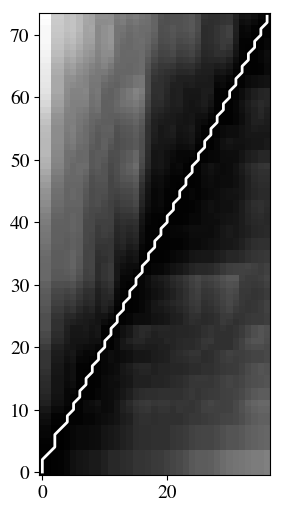

In [112]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"),  interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

### fastdtw

You might want to install the fastdtw package for dealing with longer series.

`pip install fastdtw`



In [113]:
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path2 = fastdtw(x, y, dist=euclidean)
print(distance)
print (path2)

0.0
[(0, 0), (0, 1), (0, 2), (1, 3), (2, 4), (2, 5), (2, 6), (3, 7), (4, 8), (4, 9), (5, 10), (5, 11), (6, 12), (6, 13), (7, 14), (7, 15), (8, 16), (8, 17), (9, 18), (9, 19), (10, 20), (10, 21), (11, 22), (11, 23), (12, 24), (12, 25), (13, 26), (13, 27), (14, 28), (14, 29), (15, 30), (15, 31), (16, 32), (16, 33), (17, 34), (17, 35), (18, 36), (18, 37), (19, 38), (19, 39), (20, 40), (20, 41), (21, 42), (21, 43), (22, 44), (22, 45), (23, 46), (23, 47), (24, 48), (24, 49), (25, 50), (25, 51), (26, 52), (26, 53), (27, 54), (27, 55), (28, 56), (28, 57), (29, 58), (29, 59), (30, 60), (30, 61), (31, 62), (31, 63), (32, 64), (32, 65), (33, 66), (33, 67), (34, 68), (34, 69), (35, 70), (35, 71), (36, 72), (36, 73)]


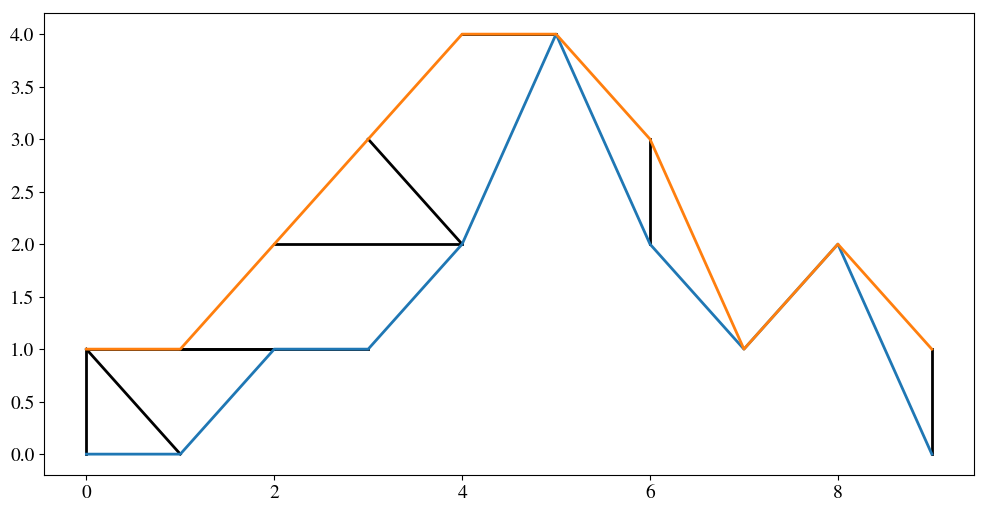

In [114]:
import itertools 

x = np.array([0, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 3, 4, 4, 3, 1, 2, 1]).reshape(-1, 1)
distance, path2 = fastdtw(x, y, dist=euclidean)

fig=plt.figure()
ax=fig.add_subplot(111)
for i, j in path2:
    plt.plot((i, j), (x[i], y[j]), color = 'black')
plt.plot(x)
plt.plot(y)

## Let's download some stock index data from Yahoo

Make sure that you have installed pandas-datareader and, for good measure:

```
pip install pandas-datareader 
pip install yahoo-finance 
pip install fix_yahoo_finance --upgrade --no-cache-dir
```

In [115]:
from pandas_datareader.data import DataReader
from datetime import datetime

dji = DataReader('^DJI',  'yahoo', datetime(2016,5,1), datetime(2016,6,1))
dji_returns = pd.DataFrame(np.diff(np.log(dji['Adj Close'].values)))
dji_returns.index = dji.index.values[1:dji.index.values.shape[0]]
dji_returns.columns = ['Dow Jones Ind. Returns']

nsdq = DataReader('^IXIC',  'yahoo', datetime(2016,5,1), datetime(2016,6,1))
nsdq_returns = pd.DataFrame(np.diff(np.log(nsdq['Adj Close'].values)))
nsdq_returns.index = nsdq.index.values[1:nsdq.index.values.shape[0]]
nsdq_returns.columns = ['NASDAQ Returns']

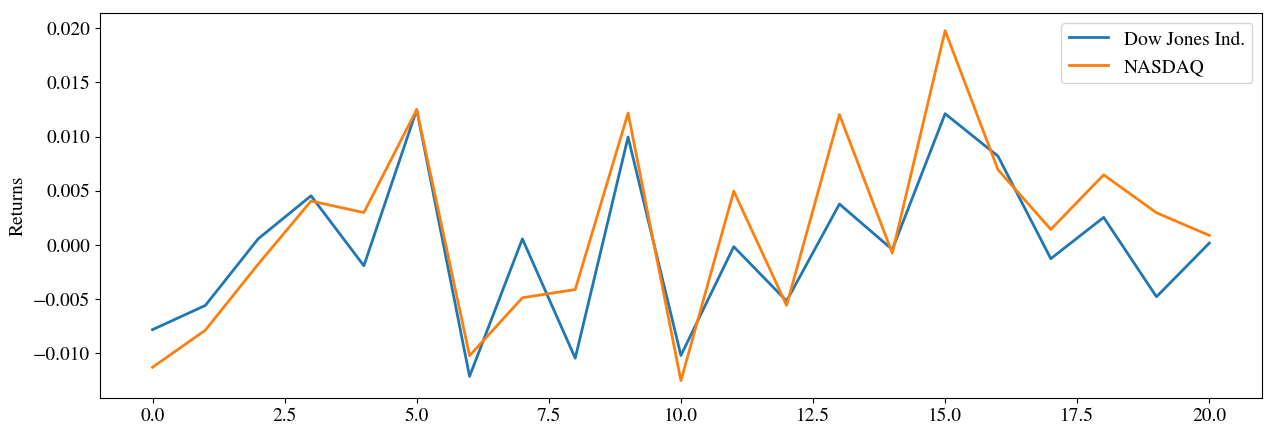

In [116]:
plt.figure(figsize=(15, 5))
plt.ylabel('Returns')
plt.plot(dji_returns['Dow Jones Ind. Returns'].values, label = 'Dow Jones Ind.')
plt.plot(nsdq_returns['NASDAQ Returns'].values, label = 'NASDAQ')
plt.legend()
plt.show()

In [117]:
dist, cost, acc, path = dtw(dji_returns['Dow Jones Ind. Returns'].values, nsdq_returns['NASDAQ Returns'].values, dist=euclidean)
print('Minimum distance found:', dist)

Minimum distance found: 0.0016267348799087465


(-0.5, 20.5)

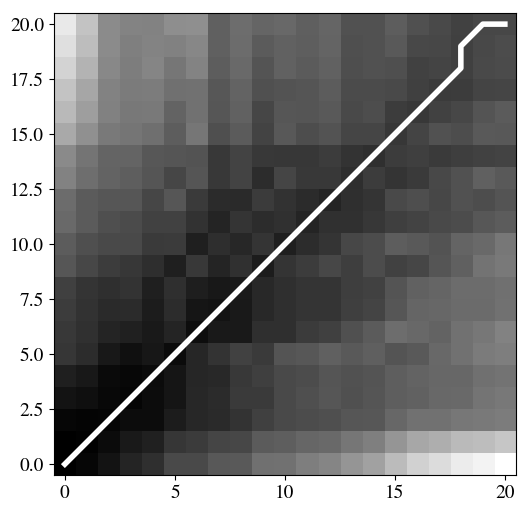

In [118]:
plt.imshow(acc.T, origin='lower', cmap=plt.get_cmap("gray"),  interpolation='nearest')
plt.plot(path[0], path[1], 'w',  linewidth=4.0 )
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))

In [119]:
distance, path2 = fastdtw(dji_returns['Dow Jones Ind. Returns'].values, nsdq_returns['NASDAQ Returns'].values, dist=euclidean)
print('Minimum distance found:', distance)

Minimum distance found: 0.06832286495616735


In [120]:
print (path2)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (18, 19), (19, 20), (20, 20)]


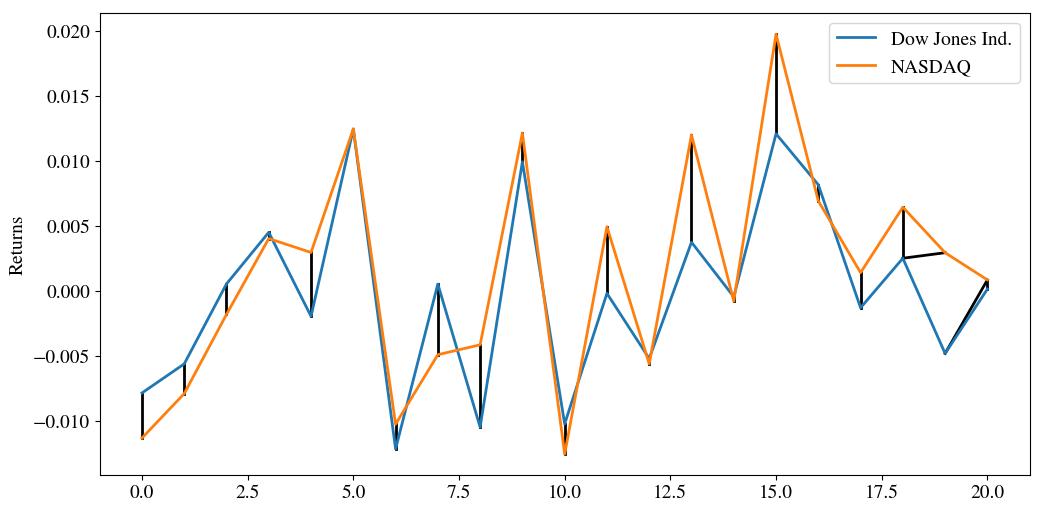

In [121]:
x = dji_returns['Dow Jones Ind. Returns'].values
y = nsdq_returns['NASDAQ Returns'].values
fig=plt.figure()
ax=fig.add_subplot(111)
for i, j in path2:
    plt.plot((i, j), (x[i], y[j]), color = 'black')
plt.ylabel('Returns')
plt.plot(x, label = 'Dow Jones Ind.')
plt.plot(y, label = 'NASDAQ')
plt.legend()
plt.show()